<div class="span5 alert alert-info">
<h1>Data Science Salaries (Code and supplementary graphics)</h1>
</div>

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

<div class="span5 alert alert-info">
<h2>Data taken from the 2018 Kaggle Data Science survery in this notebook is limited to those who: </h2>

<h3> (1) live in the USA, </h3>
    
<h3> (2) share their salary details, and </h3>

<h3> (3) are employed as Data Scientists </h3>

</div>

In [2]:
df = pd.read_csv("/Users/victor/Downloads/kaggle-survey-2018/multipleChoiceResponses.csv",skiprows=1)

# 1
df = df.loc[df["In which country do you currently reside?"]=="United States of America"]

# Cleaning up the labels
df = df.iloc[:,[1,3,5,6,7,9,11,12]]

df.columns = ["Gender","Age","Education","Major",
              "Occupation","Industry","Experience",
              "Salary"]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4716 entries, 0 to 23824
Data columns (total 8 columns):
Gender        4716 non-null object
Age           4716 non-null object
Education     4662 non-null object
Major         4614 non-null object
Occupation    4584 non-null object
Industry      4366 non-null object
Experience    4286 non-null object
Salary        4151 non-null object
dtypes: object(8)
memory usage: 331.6+ KB


In [3]:
# 2 and 3
df = df.dropna(subset=['Salary'])
df = df[~df.isin(['I am a student', 
                  'I do not wish to disclose my approximate yearly compensation',
                  'Student',
                  'Not employed']).any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2820 entries, 11 to 23775
Data columns (total 8 columns):
Gender        2820 non-null object
Age           2820 non-null object
Education     2820 non-null object
Major         2816 non-null object
Occupation    2820 non-null object
Industry      2820 non-null object
Experience    2819 non-null object
Salary        2820 non-null object
dtypes: object(8)
memory usage: 198.3+ KB


In [4]:
df = df[(df.Occupation=="Data Scientist")]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 11 to 23536
Data columns (total 8 columns):
Gender        777 non-null object
Age           777 non-null object
Education     777 non-null object
Major         776 non-null object
Occupation    777 non-null object
Industry      777 non-null object
Experience    777 non-null object
Salary        777 non-null object
dtypes: object(8)
memory usage: 54.6+ KB


<div class="span5 alert alert-warning">
<h2>There was 1 individual with a missing Major.</h2>

<h3> "Unknown" replaced the missing Major.</h3>

</div>

In [5]:
df = df.fillna("Unknown")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 11 to 23536
Data columns (total 8 columns):
Gender        777 non-null object
Age           777 non-null object
Education     777 non-null object
Major         777 non-null object
Occupation    777 non-null object
Industry      777 non-null object
Experience    777 non-null object
Salary        777 non-null object
dtypes: object(8)
memory usage: 54.6+ KB


<div class="span5 alert alert-info">
<h2> Feature engineering for a linear and logistic regression model </h2>
</div>

In [6]:
#Salary for linear regession
dictionary = {'0-10,000'    : 5000,
              '10-20,000'   : 15000,
              '20-30,000'   : 25000,
              '30-40,000'   : 35000,
              '40-50,000'   : 45000,
              '50-60,000'   : 55000,
              '60-70,000'   : 65000,
              '70-80,000'   : 75000,
              '80-90,000'   : 85000,
              '90-100,000'  : 95000,
              '100-125,000' : 112500,
              '125-150,000' : 137500,
              '150-200,000' : 175000,
              '200-250,000' : 225000,
              '250-300,000' : 275000,
              '300-400,000' : 350000,
              '400-500,000' : 450000,
              '500,000+'    : 500000
             }
df['Sal_Mid'] = df.Salary.apply(lambda x: dictionary[x])    
                    
#Age for linear regession
dictionary = {'18-21' : 19.5,
              '22-24' : 23,
              '25-29' : 27,
              '30-34' : 32,
              '35-39' : 37,
              '40-44' : 42,
              '45-49' : 47,
              '50-54' : 52,
              '55-59' : 57,
              '60-69' : 64.5,
              '70-79' : 74.5,
              '80+'   : 80
             }
df['Age_Mid'] = df['Age'].apply(lambda x: dictionary[x])

#Experience for linear regession
dictionary = {'0-1'    : .5,
              '1-2'    : 1.5,
              '2-3'    : 2.5,
              '3-4'    : 3.5,
              '4-5'    : 4.5,
              '5-10'   : 7.5,
              '10-15'  : 12.5,
              '15-20'  : 17.5,
              '20-25'  : 22.5,
              '25-30'  : 27.5,
              '30 +'   : 30
            }
df['Experience_Mid'] = df['Experience'].apply(lambda x: dictionary[x])

#For logistic regression
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

<div class = "span5 alert alert-info">
    <h2> Reordering the columns </h2>
    </div>

In [7]:
df = df[["Gender","Education","Major","Industry","Age",
         "Experience","Salary","Age_Mid","Experience_Mid","Sal_Mid"]]

<div class = "span alert alert-info">
    <h2> Count Plots </h2>
    </div>

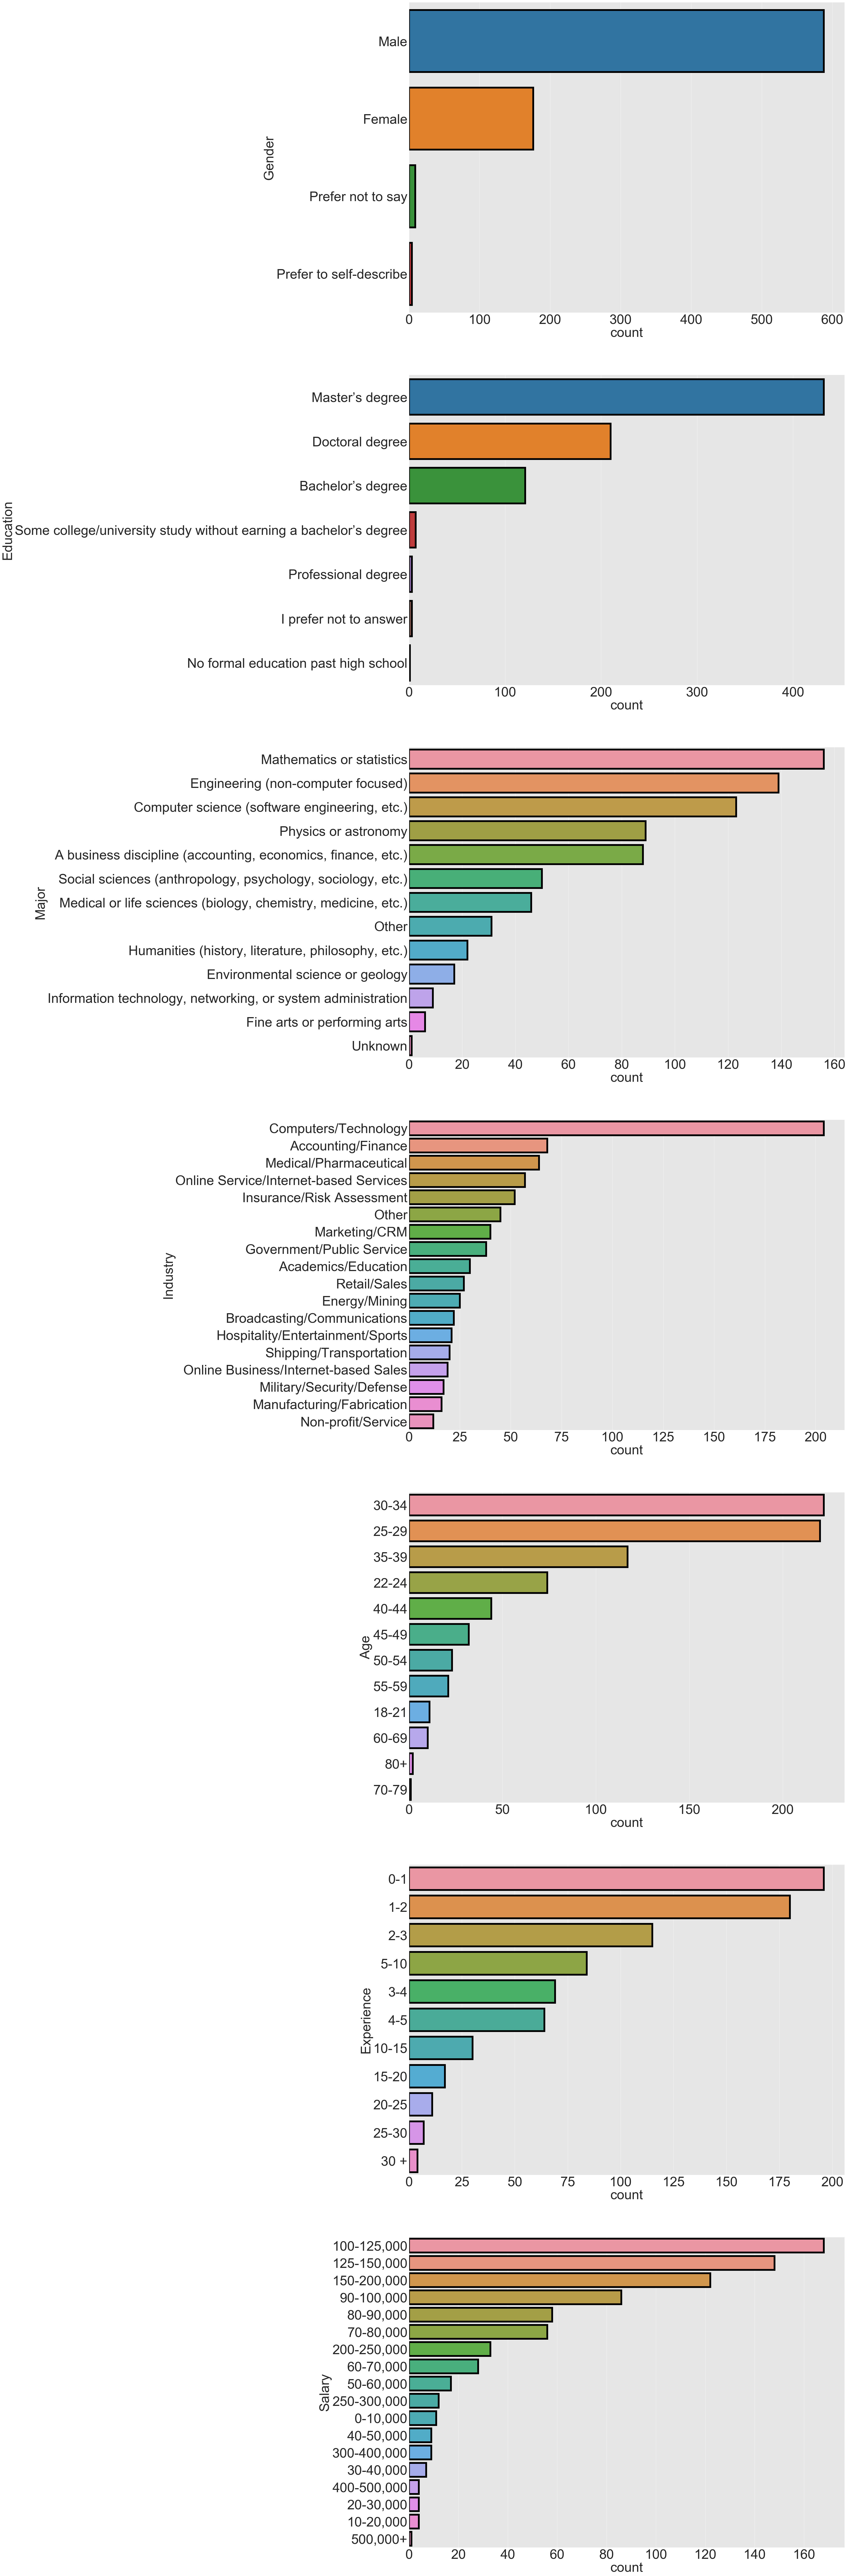

In [8]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
mpl.rcParams['font.size'] = 60.0
cols = df.columns
num_of_plots = len(cols) - 3
fig, ax = plt.subplots(num_of_plots,1, figsize=(5*num_of_plots, 30*num_of_plots))

z = 0
for column in df.columns[:num_of_plots]:
    sns.countplot(y = df[column], edgecolor = "black", 
                  linewidth = 8, ax = ax[z], order=df[column].value_counts().index)
    z += 1     
fig.show()

In [9]:
df = df[(df.Gender=="Male") | 
         (df.Gender=="Female")
        ]

# the apostrophes used below are not the standard ones used on a keyboard
# I copy and pasted the bachelors and masters text below from a value_counts print
df = df[(df.Education=="Bachelor’s degree") | 
          (df.Education=="Master’s degree") |
          (df.Education=="Doctoral degree")
         ]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751 entries, 11 to 23536
Data columns (total 10 columns):
Gender            751 non-null object
Education         751 non-null object
Major             751 non-null object
Industry          751 non-null object
Age               751 non-null object
Experience        751 non-null object
Salary            751 non-null object
Age_Mid           751 non-null float64
Experience_Mid    751 non-null float64
Sal_Mid           751 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 64.5+ KB


In [11]:
dictionary = {'Master’s degree'    : "Master's", 
              'Bachelor’s degree'  : "Bachelor's",
              'Doctoral degree'    : "Doctoral"
             }
df.Education = df.Education.apply(lambda x: dictionary[x])

dictionary = {'Social sciences (anthropology, psychology, sociology, etc.)'   : 'Social Sci',
              'Mathematics or statistics'                                     : 'Math/Stats', 
              'Engineering (non-computer focused)'                            : 'Engineering',
              'Computer science (software engineering, etc.)'                 : 'Comp Sci',
              'Physics or astronomy'                                          : 'Phys/Astron',
              'A business discipline (accounting, economics, finance, etc.)'  : 'Business',
              'Medical or life sciences (biology, chemistry, medicine, etc.)' : 'Medic Sci',
              'Fine arts or performing arts'                                  : 'Other',
              'Information technology, networking, or system administration'  : 'Other',
              'Environmental science or geology'                              : 'Other', 
              'Other'                                                         : 'Other',
              'Humanities (history, literature, philosophy, etc.)'            : 'Other',
              'I never declared a major'                                      : 'Other',
              'Unknown'                                                       : 'Other'
             }
df['Major'] = df['Major'].apply(lambda x: dictionary[x])

dictionary = {'Other'                                  : "Other",
              'Marketing/CRM'                          : "Marketing", 
              'Insurance/Risk Assessment'              : "Risk_Asse",
              'Computers/Technology'                   : "Technology", 
              'Broadcasting/Communications'            : "Other",
              'Academics/Education'                    : "Other", 
              'Accounting/Finance'                     : "Finance",
              'Medical/Pharmaceutical'                 : "Medical", 
              'Non-profit/Service'                     : "Other",
              'Online Service/Internet-based Services' : "Online_Serv",
              'Shipping/Transportation'                : "Other", 
              'Energy/Mining'                          : "Other", 
              'Retail/Sales'                           : "Other" ,
              'Military/Security/Defense'              : "Other",
              'Online Business/Internet-based Sales'   : "Other",
              'Manufacturing/Fabrication'              : "Other", 
              'Government/Public Service'              : "Government",
              'Hospitality/Entertainment/Sports'       : "Other"
             }
df['Industry'] = df['Industry'].apply(lambda x: dictionary[x])  
                    
#Age
dictionary = {'18-21' : "Other",
              '22-24' : '22-24',
              '25-29' : '25-29',
              '30-34' : '30-34',
              '35-39' : '35-39',
              '40-44' : '40-44',
              '45-49' : '45-49',
              '50-54' : "Other",
              '55-59' : "Other",
              '60-69' : "Other",
              '70-79' : "Other",
              '80+'   : "Other"
             }
df['Age'] = df['Age'].apply(lambda x: dictionary[x])

#Experience for linear regession
dictionary = {'0-1'    : '0-1',
              '1-2'    : '1-2',
              '2-3'    : '2-3',
              '3-4'    : '3-4',
              '4-5'    : '4-5',
              '5-10'   : '5-10',
              '10-15'  : '>10',
              '15-20'  : '>10',
              '20-25'  : '>10',
              '25-30'  : '>10',
              '30 +'   : '>10'
            }
df['Experience'] = df['Experience'].apply(lambda x: dictionary[x])

#For logistic regression
df['Sal_Lor'] = df.Sal_Mid > df.Sal_Mid.median()

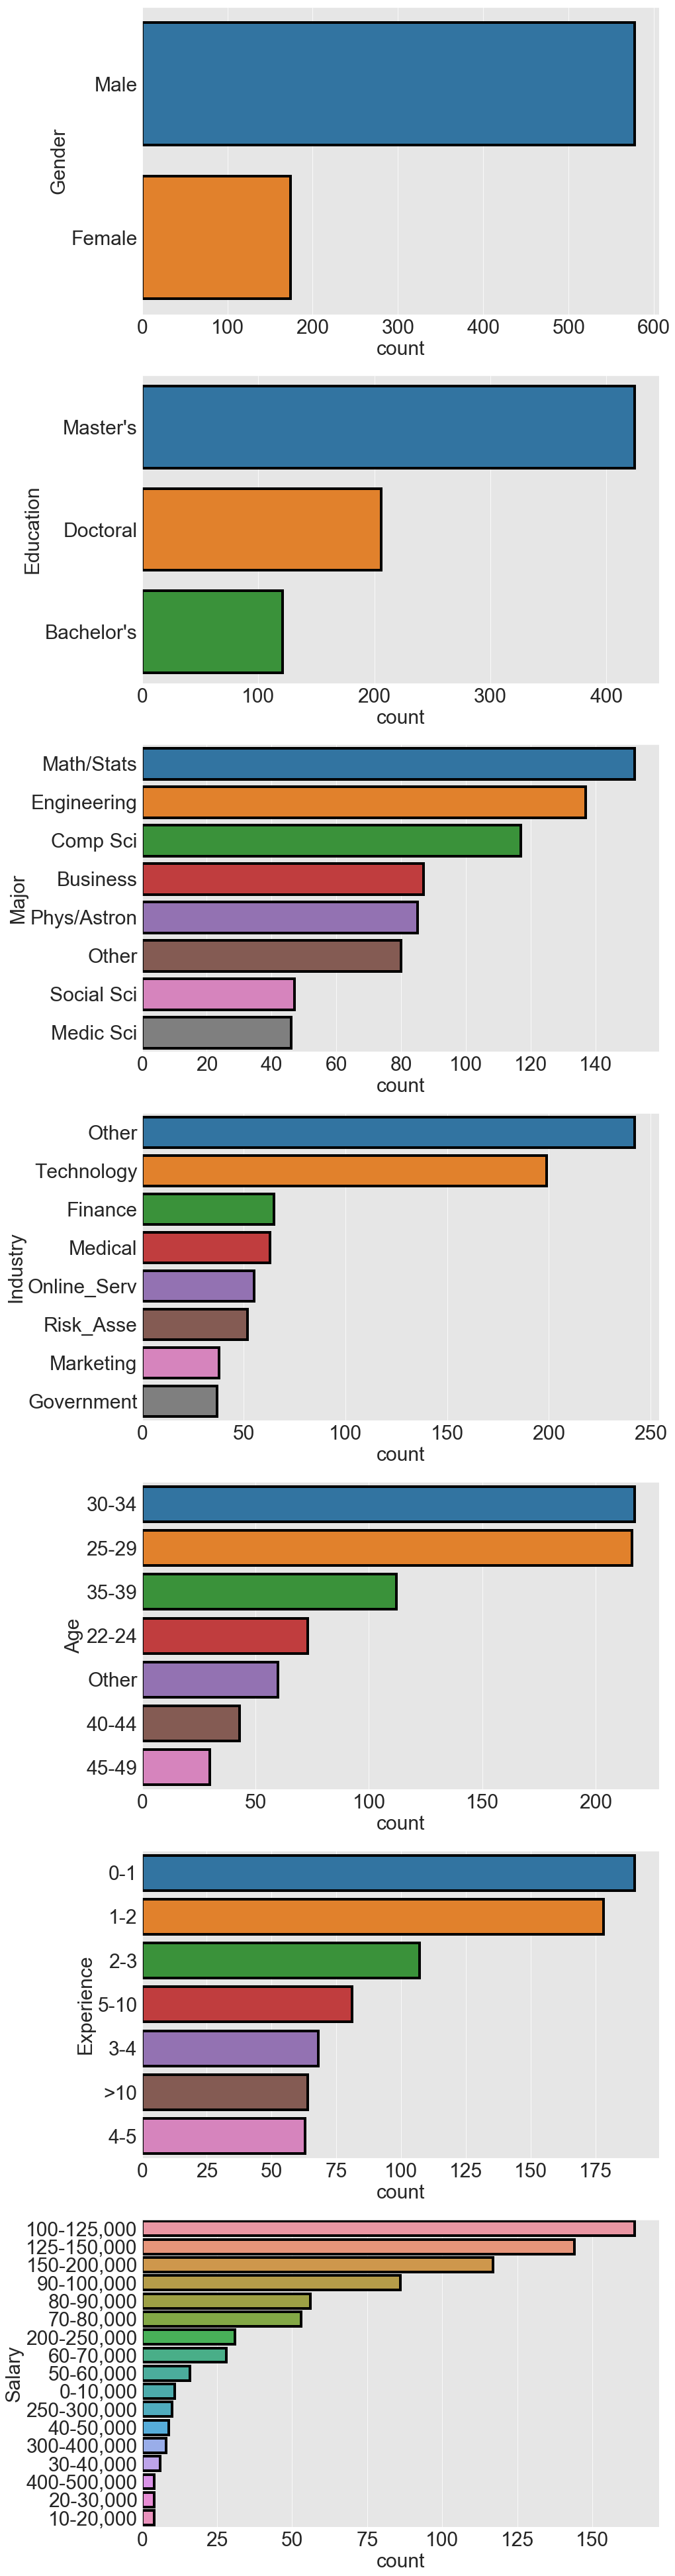

In [13]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
mpl.rcParams['font.size'] = 30.0
cols = df.columns
num_of_plots = len(cols) - 4
fig, ax = plt.subplots(num_of_plots,1, figsize=(2*num_of_plots, 10*num_of_plots))

z = 0
for column in df.columns[:num_of_plots]:
    sns.countplot(y = df[column], edgecolor = "black", 
                  linewidth = 4, ax = ax[z], order=df[column].value_counts().index)
    z += 1     
fig.show()

<div class = "span alert alert-success">
    <h2> User-Defined Functions for Statistics</h2>
    </div>

In [15]:
def sorted_by_mean(df, by, column):
    #example: sorted_by_mean(df, "Major", "Sal_Mid")
    df = pd.DataFrame({col:vals[column] for 
                        col, vals in 
                        df.groupby([by])}).mean().sort_values(ascending=False)
    return df.index

def t_test(df, column, a, b):
    # example: ttest(df,"Education","Bachelor's","Master's")  
    fea_a = df[df[column] == a]
    fea_b = df[df[column] == b]
    t,p = stats.ttest_ind(fea_a.Sal_Mid,
                          fea_b.Sal_Mid, 
                          equal_var = False)
    print(a, "vs", b, "p-value:", "{:.3f}".format(p))

def plot(df, column, order, palette):
    # example boxplot(df, "Experience", exp_order, "Blues_r")
    if palette == "Blues_r":
        title = "(Averaged Salaries)"
        
    if palette == "Greens_r":
        title = "(Salary > Median)"
        
    if palette == "Reds_r":
        title = "(Salary <= Median)"
        
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize = (20, 12))
    mpl.rcParams['font.size'] = 30

    ax = sns.boxplot(x = df["Sal_Mid"], y = df[column], notch = True,
                     linewidth = 4, palette = palette, order = order, showmeans=True, 
                     meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", 
                                      "markeredgewidth":4 ,"markersize":20})
    
#     medians = df.groupby([column])["Sal_Mid"].median()
#     medians = medians[order].values
#     nobs = df[column].value_counts()
#     nobs = nobs[order].values
#     nobs = [str(x) for x in nobs.tolist()]
#     nobs = [i for i in nobs]
#     pos = range(len(nobs))
#     for tick,label in zip(pos,ax.get_xticklabels()):
#         ax.text(medians[tick], pos[tick], nobs[tick], 
#                 bbox=dict(facecolor='black', alpha=0.5),
#                 horizontalalignment='left', verticalalignment='bottom',
#                 size='small', color='white', weight='bold')
        
#     sns.swarmplot(x = df["Sal_Mid"], y = df[column],
#                 linewidth = 4, color="grey", order = order)

    plt.xlim(0,400000)
    plt.title(column + " vs Salary " + title)
    #if palette == "Blues_r":
    #    plt.axvline(df["Sal_Mid"].median(), color = 'r', linestyle = '-', linewidth= 8)
    return plt.show()

def tukey(df,feature):
    mc = MultiComparison(df["Sal_Mid"], df[feature])
    print(mc.tukeyhsd())

<div class = "span alert alert-success">
    <h2> Variable assignments for Statistics </h2>
    </div>

In [16]:
top_df = df[df.Sal_Mid>df.Sal_Mid.median()]
btm_df = df[df.Sal_Mid<=df.Sal_Mid.median()]

exp_order = (['>10','5-10','4-5','3-4','2-3','1-2','0-1'])

edu_order = (["Doctoral","Master's","Bachelor's"])

gen_order = (["Male","Female"])

age_order = (['45-49', '40-44','35-39','30-34', '25-29','22-24', 'Other'])

maj_order= sorted_by_mean(df, "Major", "Sal_Mid")

ind_order= sorted_by_mean(df, "Industry", "Sal_Mid")

<div class = "span alert alert-success">
    <h2> Boxplots and Statistics </h2>
    </div>

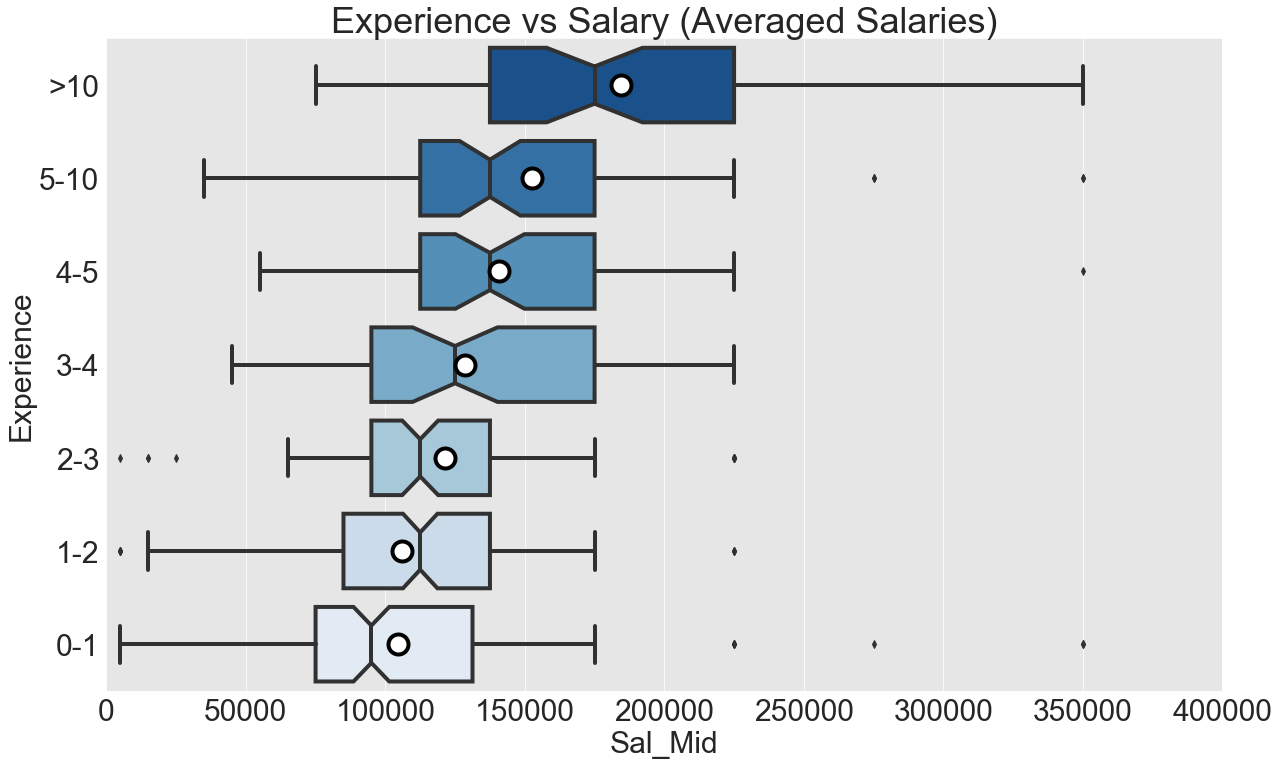

0-1     190
1-2     178
2-3     107
5-10     81
3-4      68
>10      64
4-5      63
Name: Experience, dtype: int64
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
group1 group2  meandiff     lower      upper    reject
------------------------------------------------------
 0-1    1-2   1415.5825  -14909.8615 17741.0265 False 
 0-1    2-3   16932.4889  -1983.8649 35848.8428 False 
 0-1    3-4   24026.7028  1910.7074  46142.6981  True 
 0-1    4-5   36055.7644  13302.638  58808.8908  True 
 0-1    5-10  47991.3905  27223.4596 68759.3214  True 
 0-1    >10   79991.7763  57372.5386 102611.014  True 
 1-2    2-3   15516.9064  -3627.7878 34661.6007 False 
 1-2    3-4   22611.1203   299.5062  44922.7344  True 
 1-2    4-5   34640.1819  11696.8684 57583.4954  True 
 1-2    5-10  46575.808   25599.6829 67551.9332  True 
 1-2    >10   78576.1938  55765.6526 101386.735  True 
 2-3    3-4   7094.2139  -17177.5073 31365.935  False 
 2-3    4-5   19123.2755  -5730.3753 43976.9262 False 
 2-3 

In [17]:
plot(df, "Experience", exp_order, "Blues_r")
print(df.Experience.value_counts())
tukey(df,"Experience")

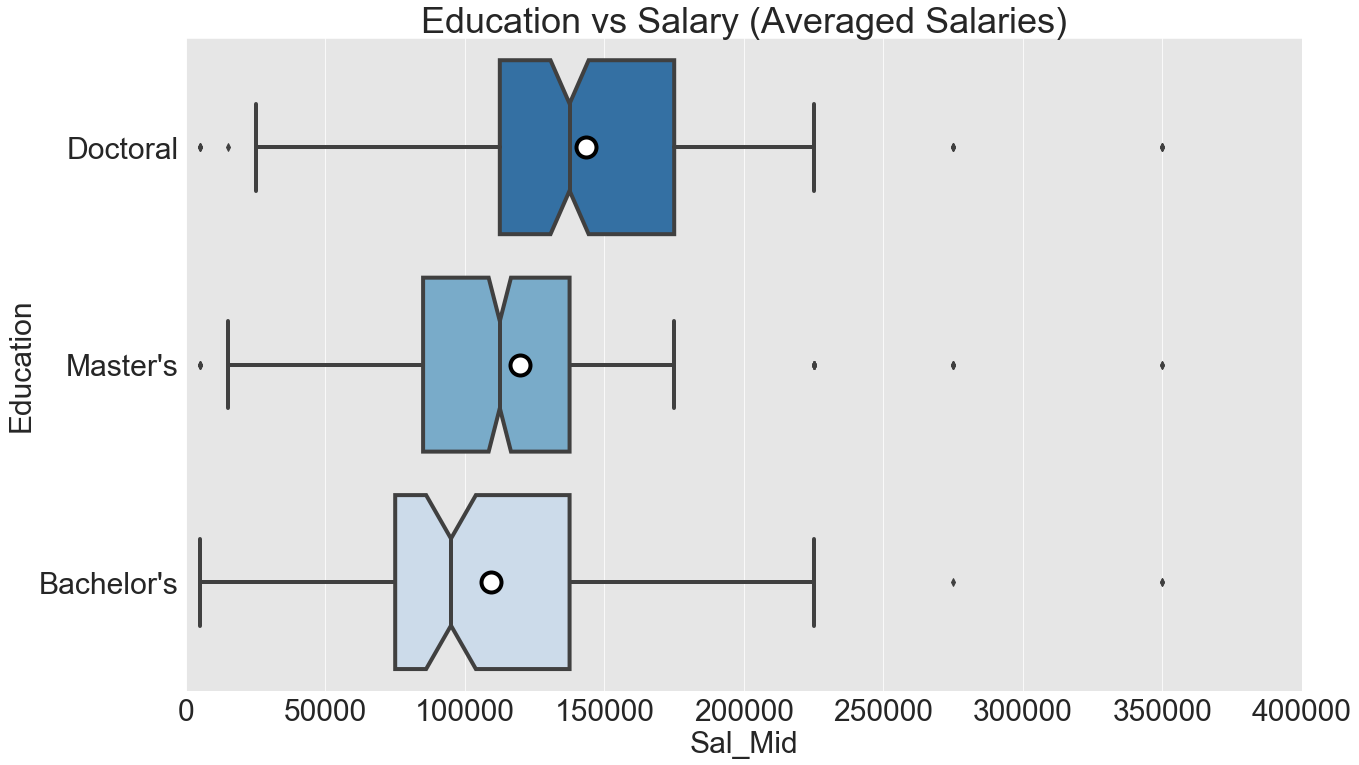

      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
  group1    group2    meandiff     lower       upper    reject
--------------------------------------------------------------
Bachelor's Doctoral  33913.5842  18599.5349  49227.6335  True 
Bachelor's Master's  10342.7608  -3437.743   24123.2646 False 
 Doctoral  Master's -23570.8234 -34926.0602 -12215.5866  True 
--------------------------------------------------------------

Bachelor's vs Master's p-value: 0.063
Master's vs Doctoral p-value: 0.000
Bachelor's vs Doctoral p-value: 0.000

Bachelor's
          Age_Mid  Experience_Mid        Sal_Mid
count  121.000000      121.000000     121.000000
mean    28.855372        3.033058  109338.842975
std      8.046334        4.590632   53943.226902
min     19.500000        0.500000    5000.000000
25%     23.000000        0.500000   75000.000000
50%     27.000000        1.500000   95000.000000
75%     32.000000        3.500000  137500.000000
max     64.500000       30.000000  350000.

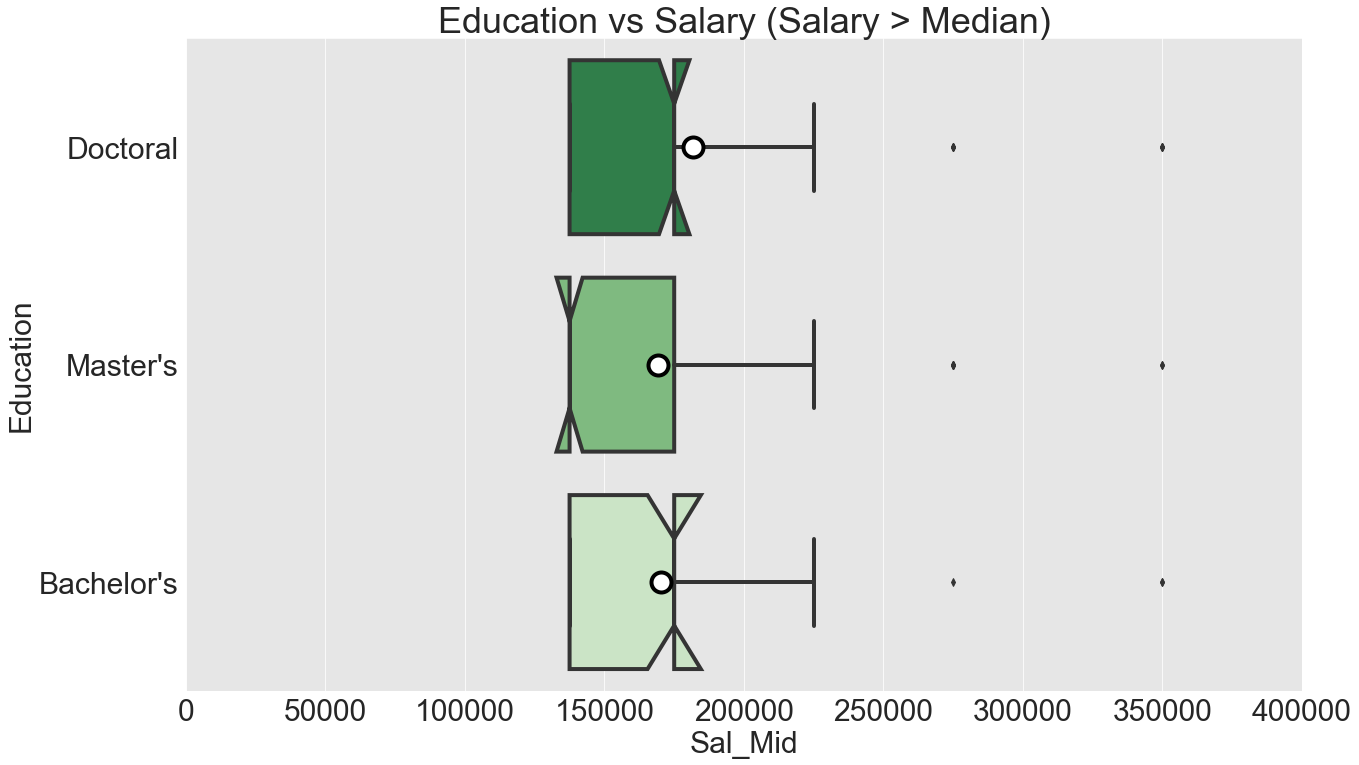

      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
  group1    group2    meandiff     lower      upper    reject
-------------------------------------------------------------
Bachelor's Doctoral  11229.1948 -12634.2137 35092.6033 False 
Bachelor's Master's  -1369.5796 -24447.3638 21708.2046 False 
 Doctoral  Master's -12598.7744 -28166.1141 2968.5654  False 
-------------------------------------------------------------

Bachelor's vs Master's p-value: 0.883
Master's vs Doctoral p-value: 0.066
Bachelor's vs Doctoral p-value: 0.266

Bachelor's
         Age_Mid  Experience_Mid        Sal_Mid
count  38.000000       38.000000      38.000000
mean   33.065789        5.236842  170394.736842
std     9.235779        5.578357   51532.351148
min    19.500000        0.500000  137500.000000
25%    27.000000        1.750000  137500.000000
50%    32.000000        3.500000  175000.000000
75%    35.750000        4.500000  175000.000000
max    57.000000       22.500000  350000.000000

Master's

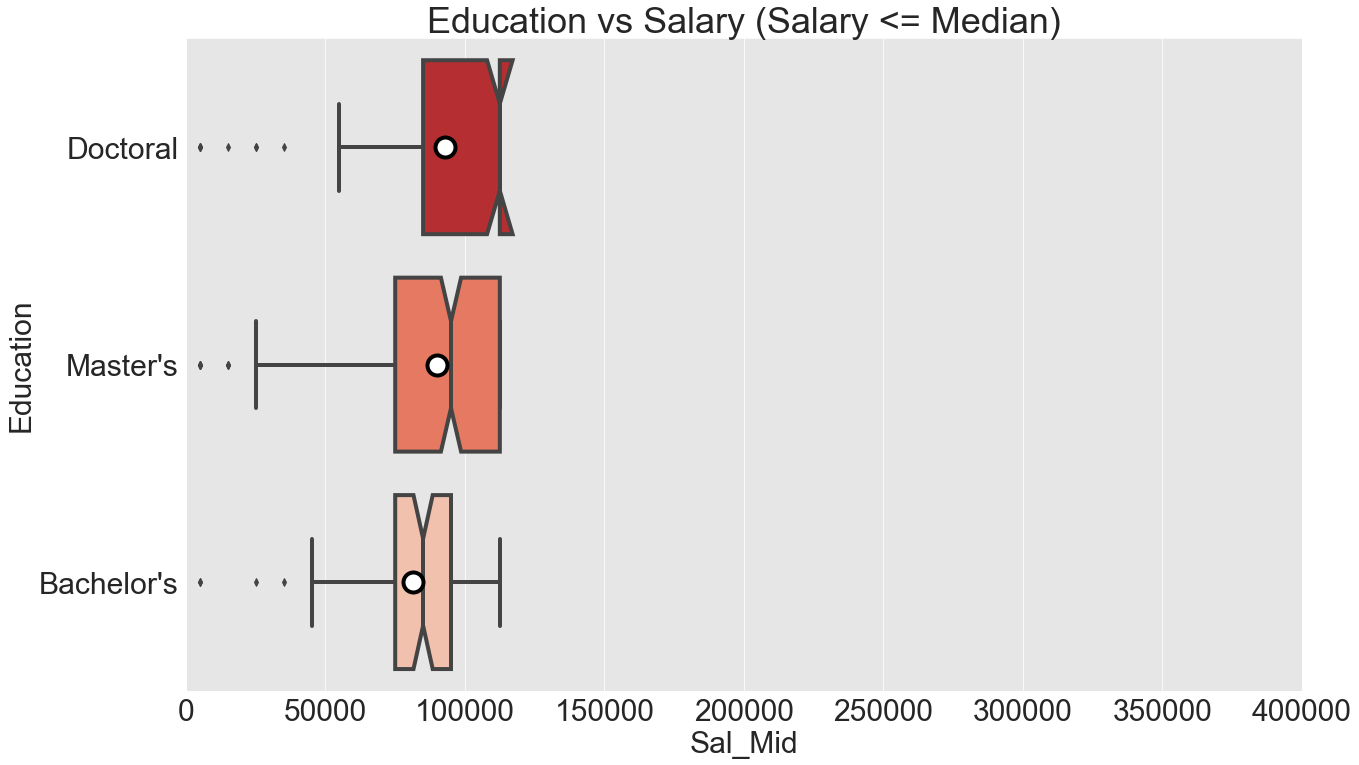

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
  group1    group2   meandiff    lower      upper    reject
-----------------------------------------------------------
Bachelor's Doctoral 11423.4466 2243.3224  20603.5708  True 
Bachelor's Master's 8689.9295  1122.5412  16257.3179  True 
 Doctoral  Master's -2733.5171 -10104.104 4637.0699  False 
-----------------------------------------------------------

Bachelor's vs Master's p-value: 0.004
Master's vs Doctoral p-value: 0.430
Bachelor's vs Doctoral p-value: 0.005

Bachelor's
         Age_Mid  Experience_Mid        Sal_Mid
count  83.000000       83.000000      83.000000
mean   26.927711        2.024096   81385.542169
std     6.654419        3.676643   23273.470359
min    19.500000        0.500000    5000.000000
25%    23.000000        0.500000   75000.000000
50%    27.000000        1.500000   85000.000000
75%    27.000000        2.000000   95000.000000
max    64.500000       30.000000  112500.000000

Master's
          Age

In [18]:
plot(df, "Education", edu_order, "Blues_r")
tukey(df,"Education")
print("")
t_test(df,"Education","Bachelor's","Master's")
t_test(df,"Education","Master's","Doctoral")    
t_test(df,"Education","Bachelor's","Doctoral")  

print("")
print("Bachelor's")
print(df[(df.Education=="Bachelor's")].describe())
print("")
print("Master's")
print(df[(df.Education=="Master's")].describe())
print("")
print("Doctoral")
print(df[(df.Education=="Doctoral")].describe())

plot(top_df, "Education", edu_order, "Greens_r")
tukey(top_df,"Education")
print("")
t_test(top_df,"Education","Bachelor's","Master's")
t_test(top_df,"Education","Master's","Doctoral")    
t_test(top_df,"Education","Bachelor's","Doctoral")  


print("")
print("Bachelor's")
print(top_df[(top_df.Education=="Bachelor's")].describe())
print("")
print("Master's")
print(top_df[(top_df.Education=="Master's")].describe())
print("")
print("Doctoral")
print(top_df[(top_df.Education=="Doctoral")].describe())

plot(btm_df, "Education", edu_order, "Reds_r")
tukey(btm_df,"Education")
print("")
t_test(btm_df,"Education","Bachelor's","Master's")
t_test(btm_df,"Education","Master's","Doctoral")    
t_test(btm_df,"Education","Bachelor's","Doctoral")  

print("")
print("Bachelor's")
print(btm_df[(btm_df.Education=="Bachelor's")].describe())
print("")
print("Master's")
print(btm_df[(btm_df.Education=="Master's")].describe())
print("")
print("Doctoral")
print(btm_df[(btm_df.Education=="Doctoral")].describe())

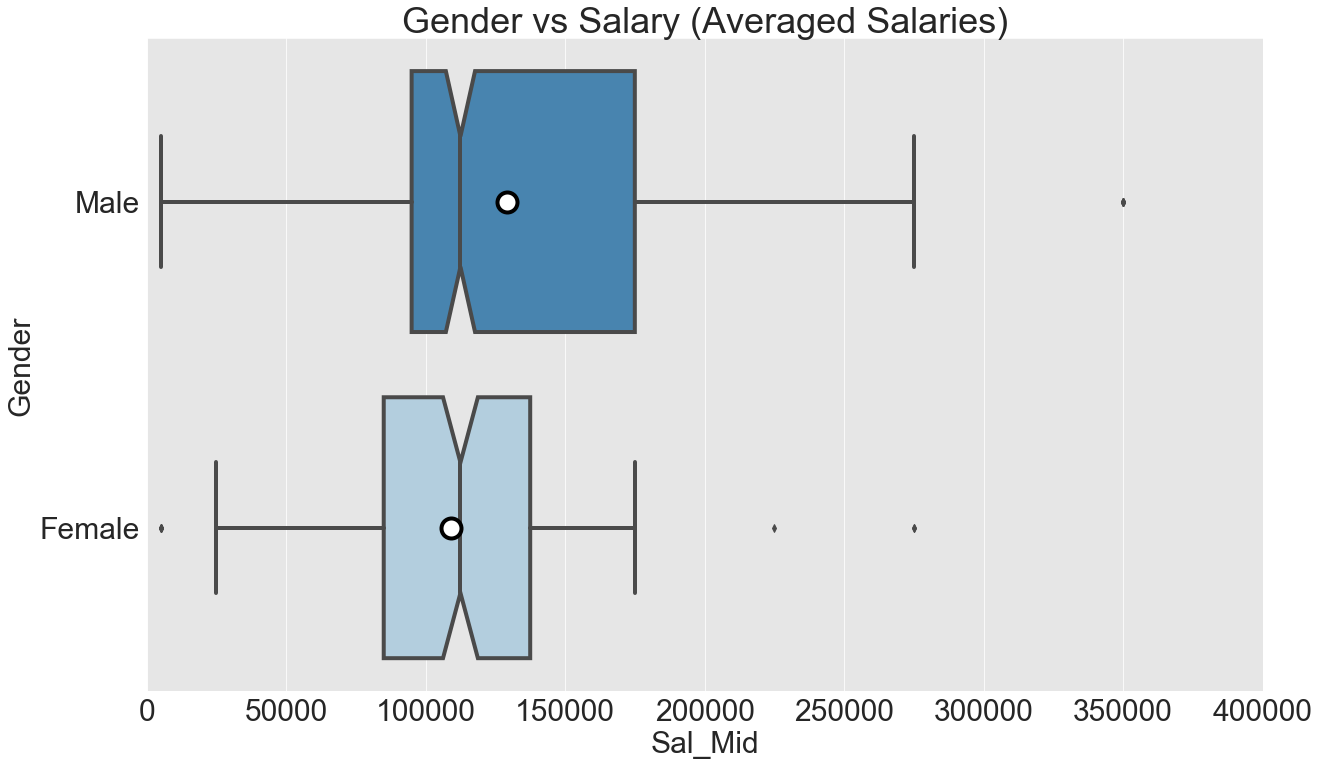


  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
Female  Male  19801.2162 10026.9114 29575.5209  True 
-----------------------------------------------------

Male vs Female p-value: 0.000


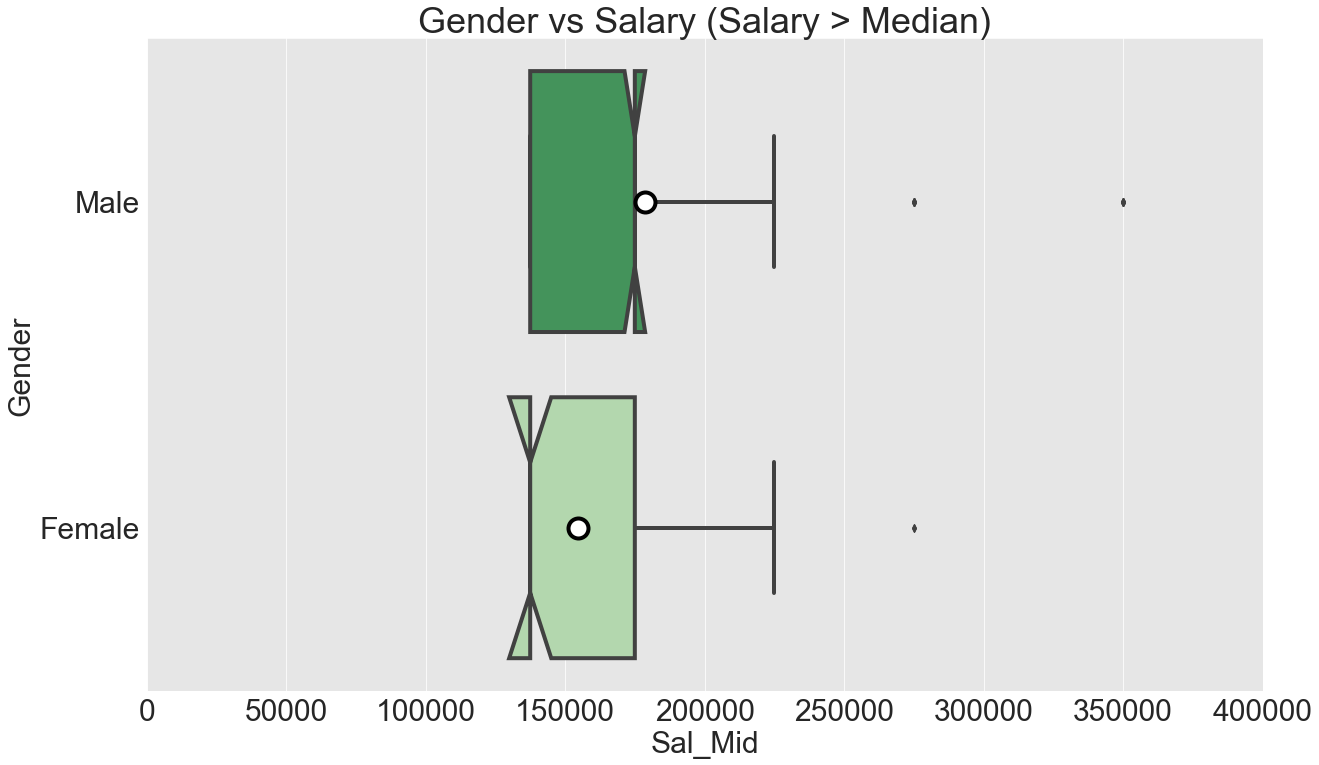


 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower     upper    reject
----------------------------------------------------
Female  Male  24049.1155 8986.4507 39111.7804  True 
----------------------------------------------------

Male vs Female p-value: 0.000

Male
          Age_Mid  Experience_Mid        Sal_Mid
count  253.000000      253.000000     253.000000
mean    37.019763        5.956522  178557.312253
std      9.384300        6.379693   57925.390538
min     19.500000        0.500000  137500.000000
25%     32.000000        1.500000  137500.000000
50%     32.000000        3.500000  175000.000000
75%     42.000000        7.500000  175000.000000
max     64.500000       30.000000  450000.000000

Female
         Age_Mid  Experience_Mid        Sal_Mid
count  61.000000       61.000000      61.000000
mean   35.040984        5.180328  154508.196721
std     8.741803        6.737972   29758.821074
min    23.000000        0.500000  137500.000000
25%    2

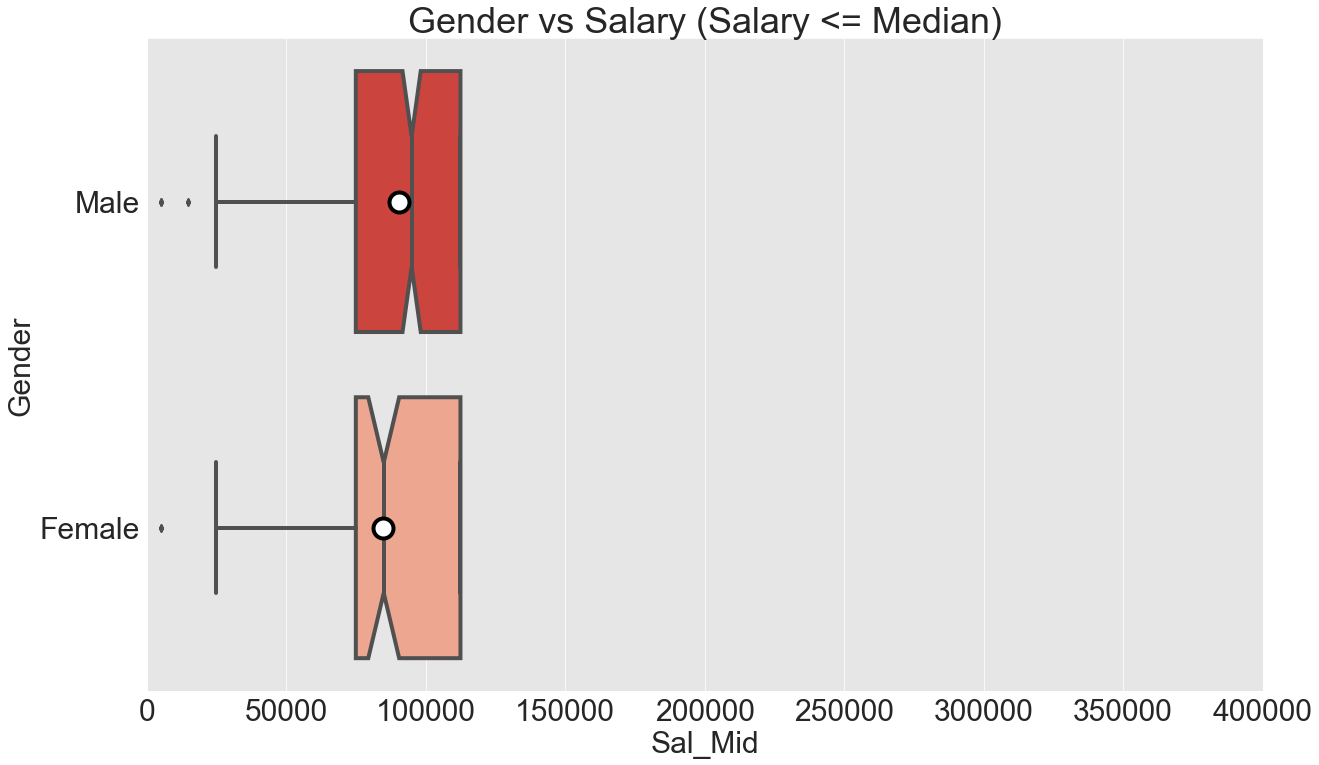


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
Female  Male  5579.25  56.1929 11102.307  True 
-----------------------------------------------

Male vs Female p-value: 0.054


In [19]:
plot(df, "Gender", gen_order, "Blues_r")
print("")
tukey(df,"Gender")
print("")
t_test(df,"Gender","Male","Female")


plot(top_df, "Gender", gen_order, "Greens_r")
print("")
tukey(top_df,"Gender")
print("")
t_test(top_df,"Gender","Male","Female")


print("")
print("Male")
print(top_df[(top_df.Gender=="Male")].describe())
print("")
print("Female")
print(top_df[(top_df.Gender=="Female")].describe())


plot(btm_df, "Gender", gen_order, "Reds_r")
print("")
tukey(btm_df,"Gender")
print("")
t_test(btm_df,"Gender","Male","Female")

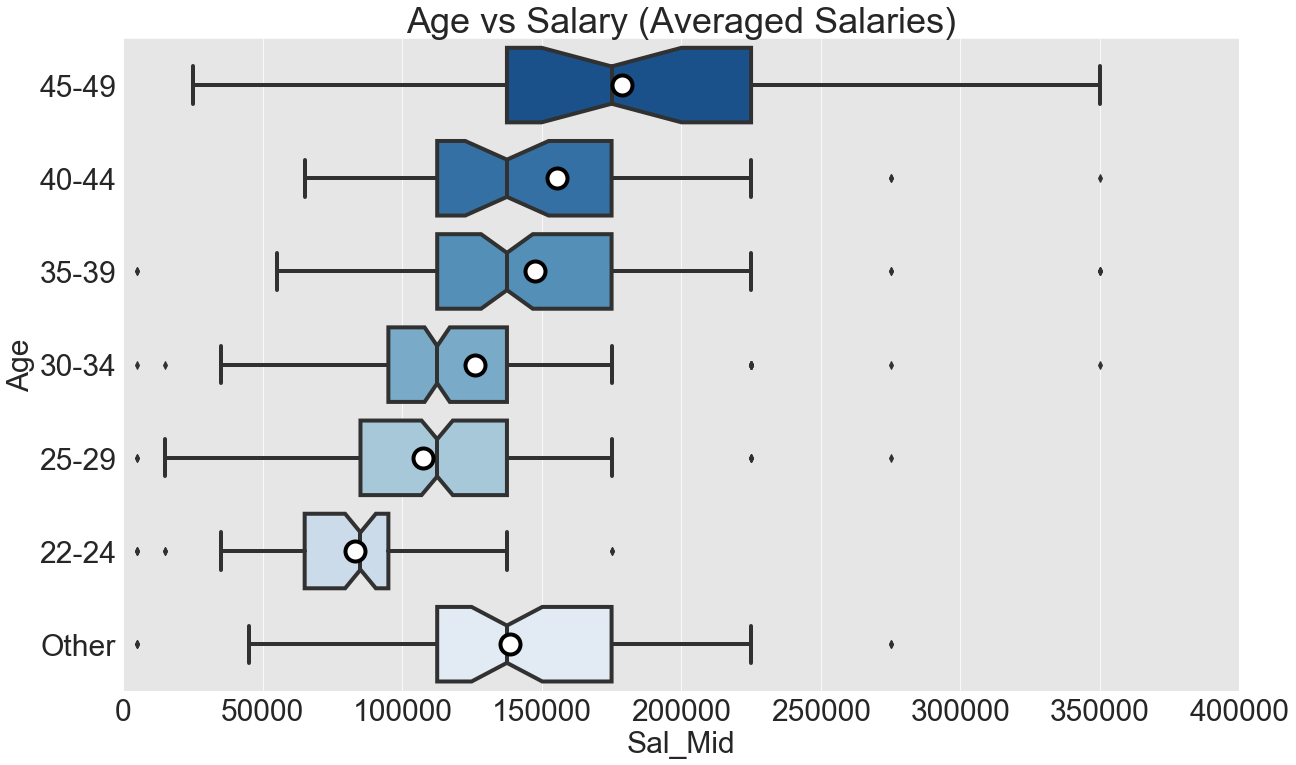

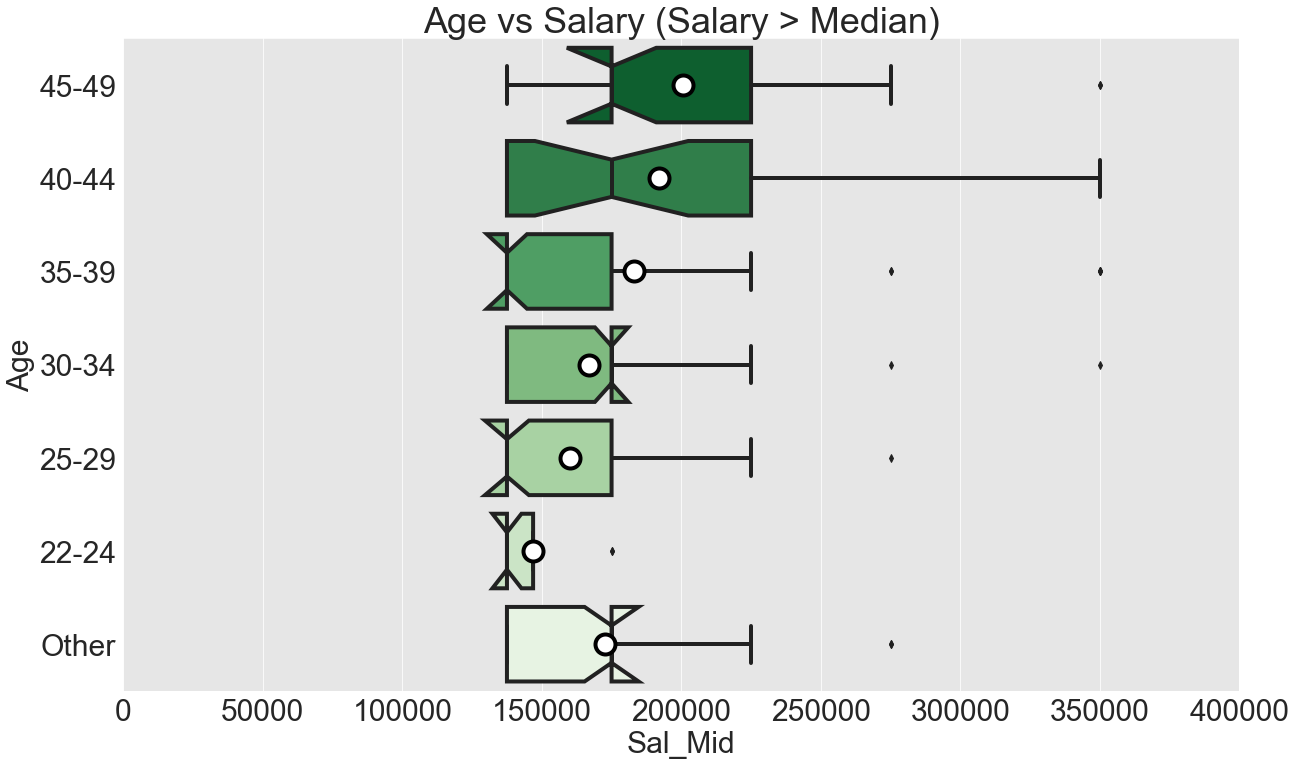

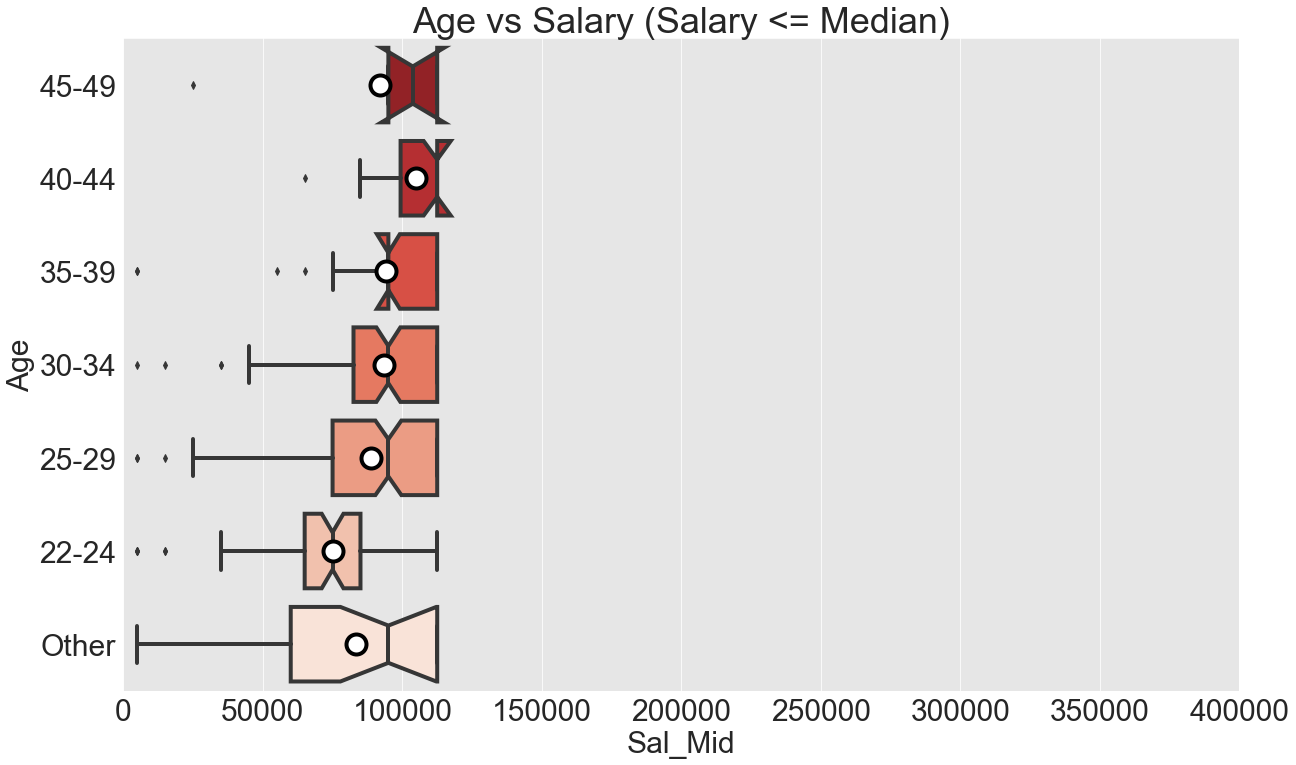

In [20]:
plot(df, "Age", age_order, "Blues_r")
plot(top_df, "Age", age_order, "Greens_r")
plot(btm_df, "Age", age_order, "Reds_r")

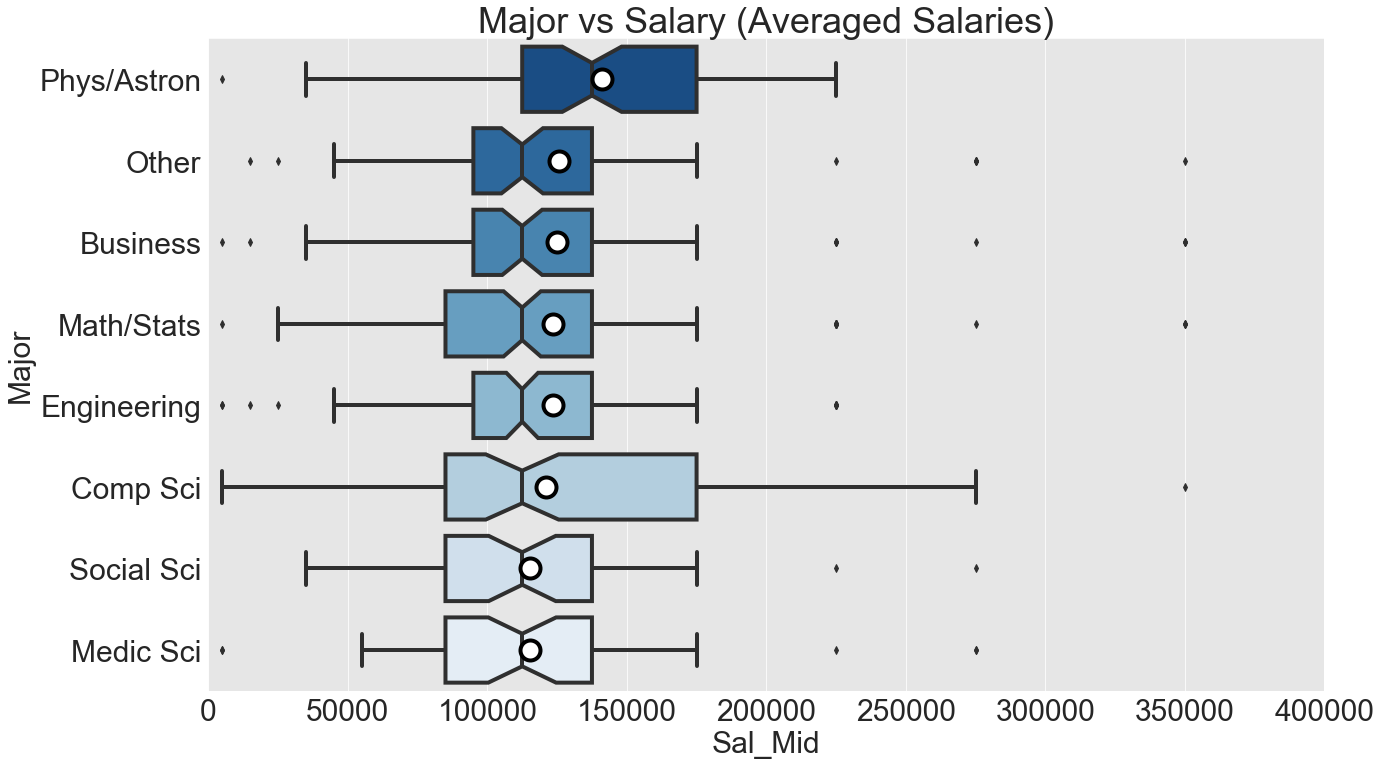

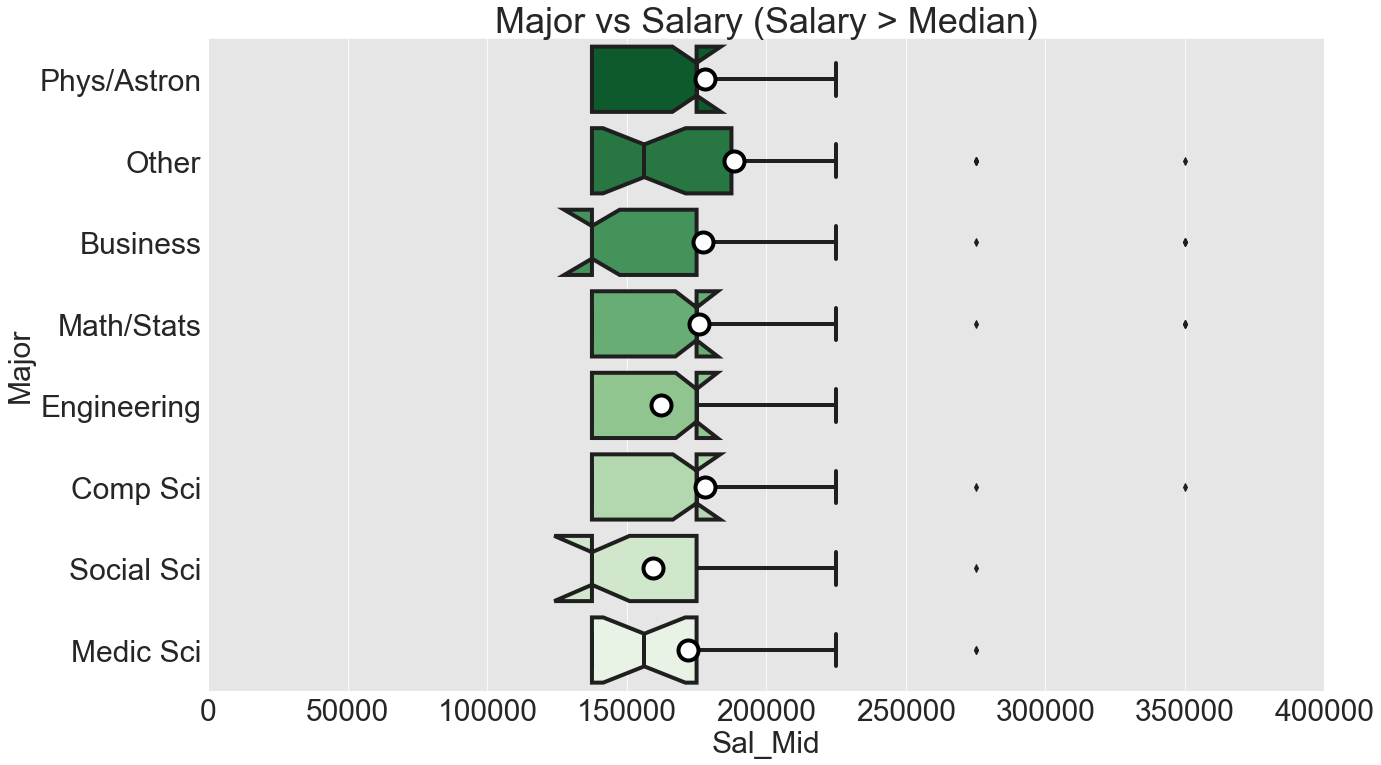

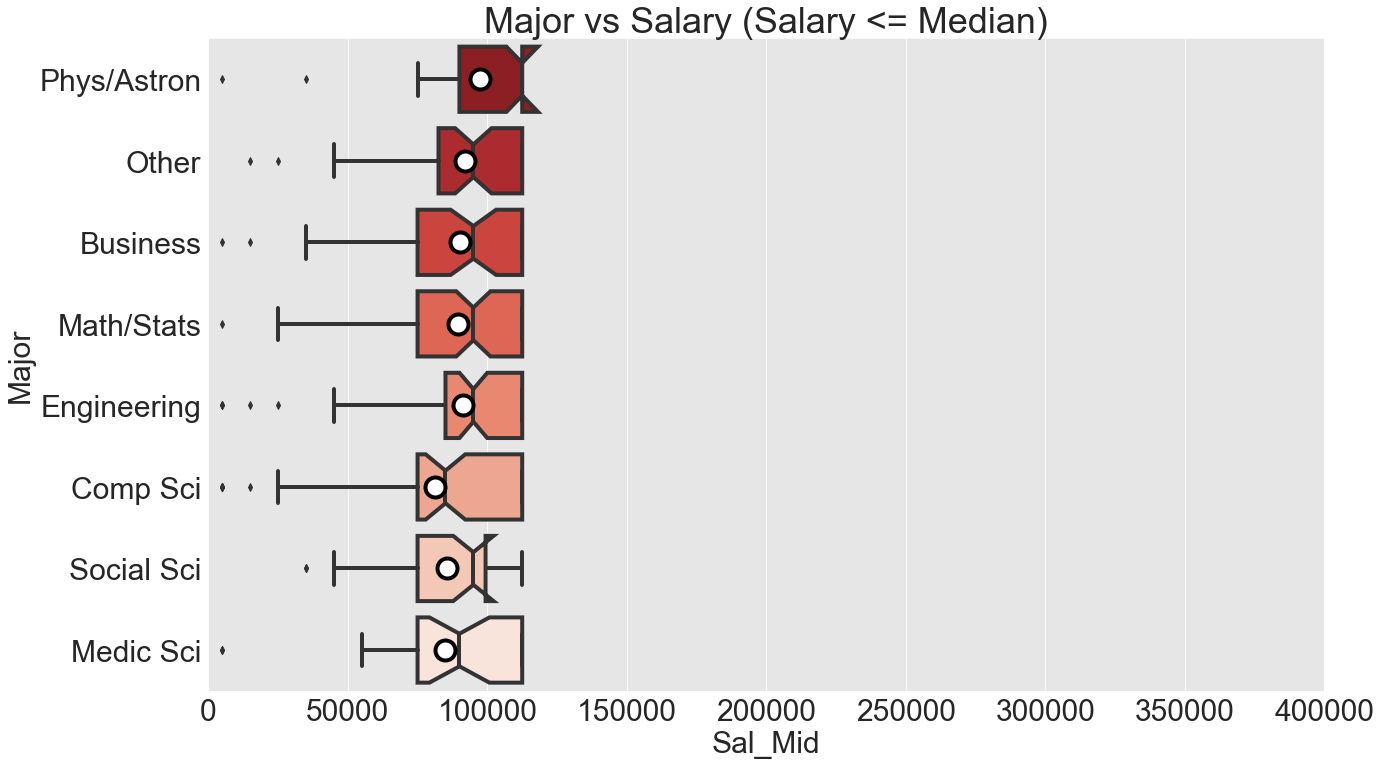

In [21]:
plot(df, "Major", maj_order, "Blues_r")
plot(top_df, "Major", maj_order, "Greens_r")
plot(btm_df, "Major", maj_order, "Reds_r")

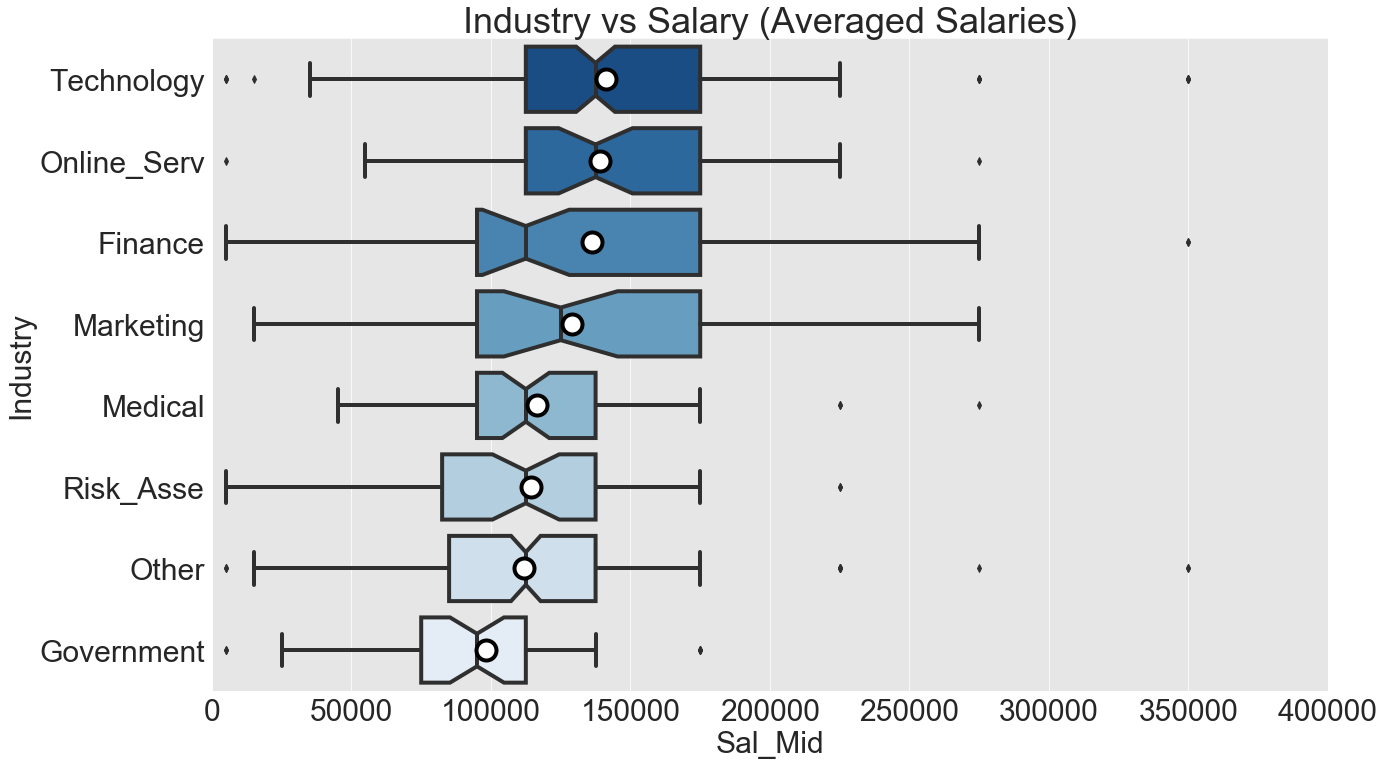

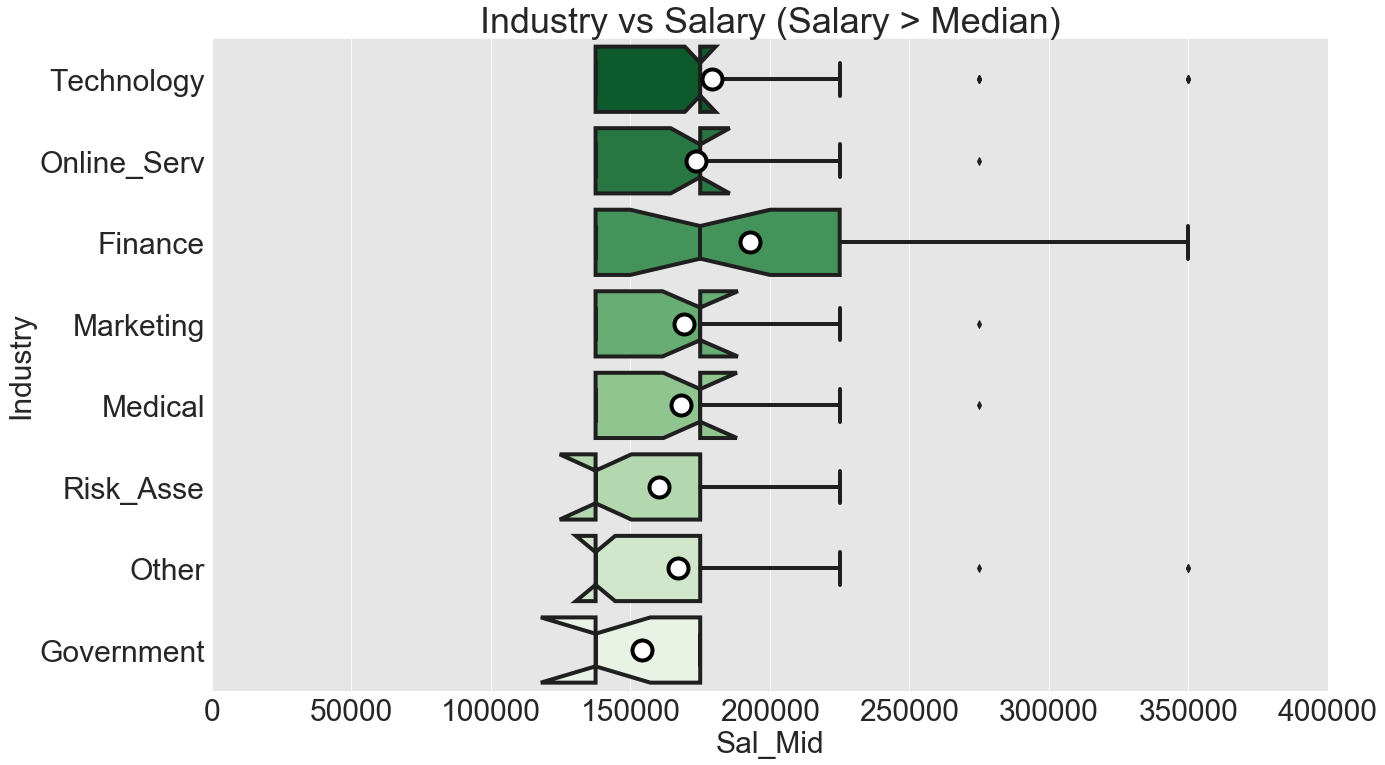

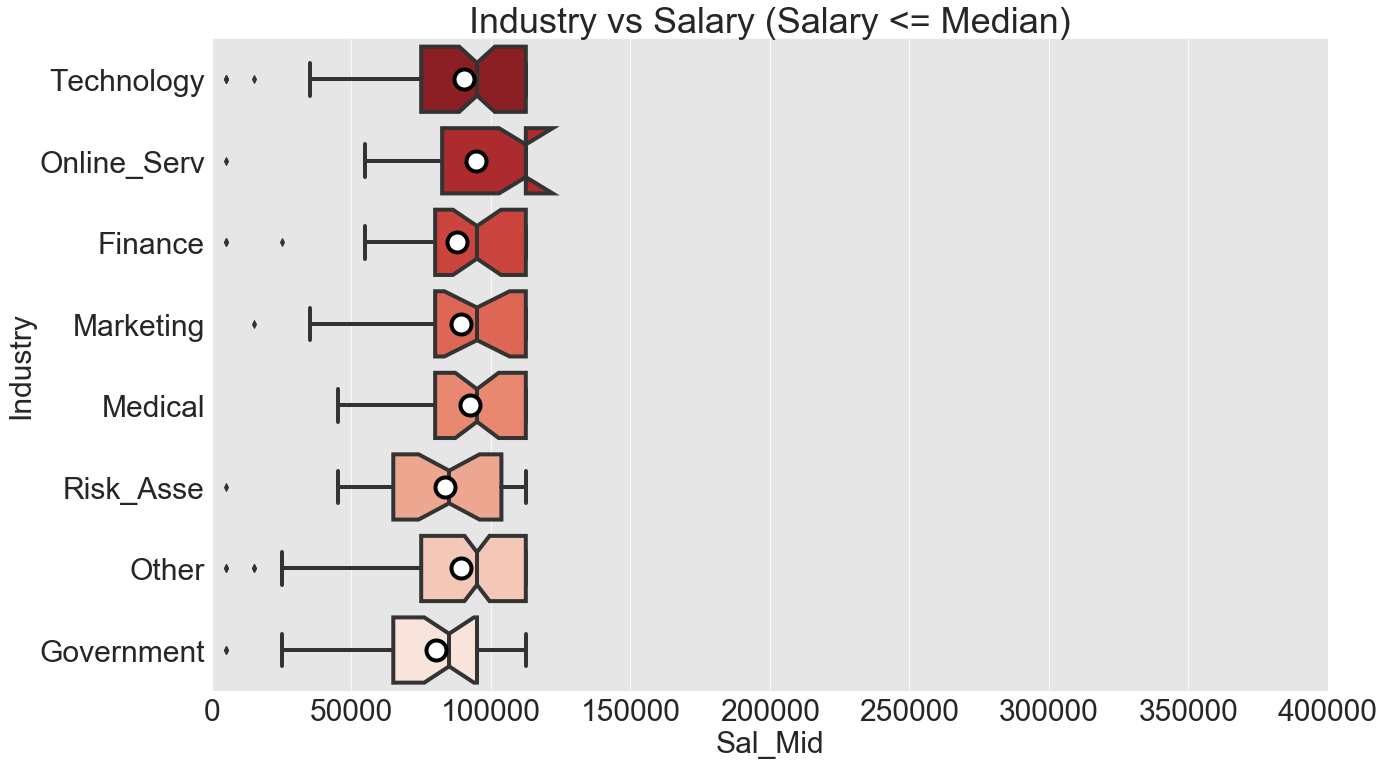

In [22]:
plot(df, "Industry", ind_order, "Blues_r")
plot(top_df, "Industry", ind_order, "Greens_r")
plot(btm_df, "Industry", ind_order, "Reds_r")

<div class = "span alert alert-success">
    <h2> Variable Assignment and User-Defined Functions for checking Simpson's paradox in Gender</h2>
    </div>

In [23]:
gen = ['#66b3ff','#ff9999']
gen_top = ['#0d61b5', '#ff6363']
gen_btm = ['#b7d7f7', '#ffd4d4']

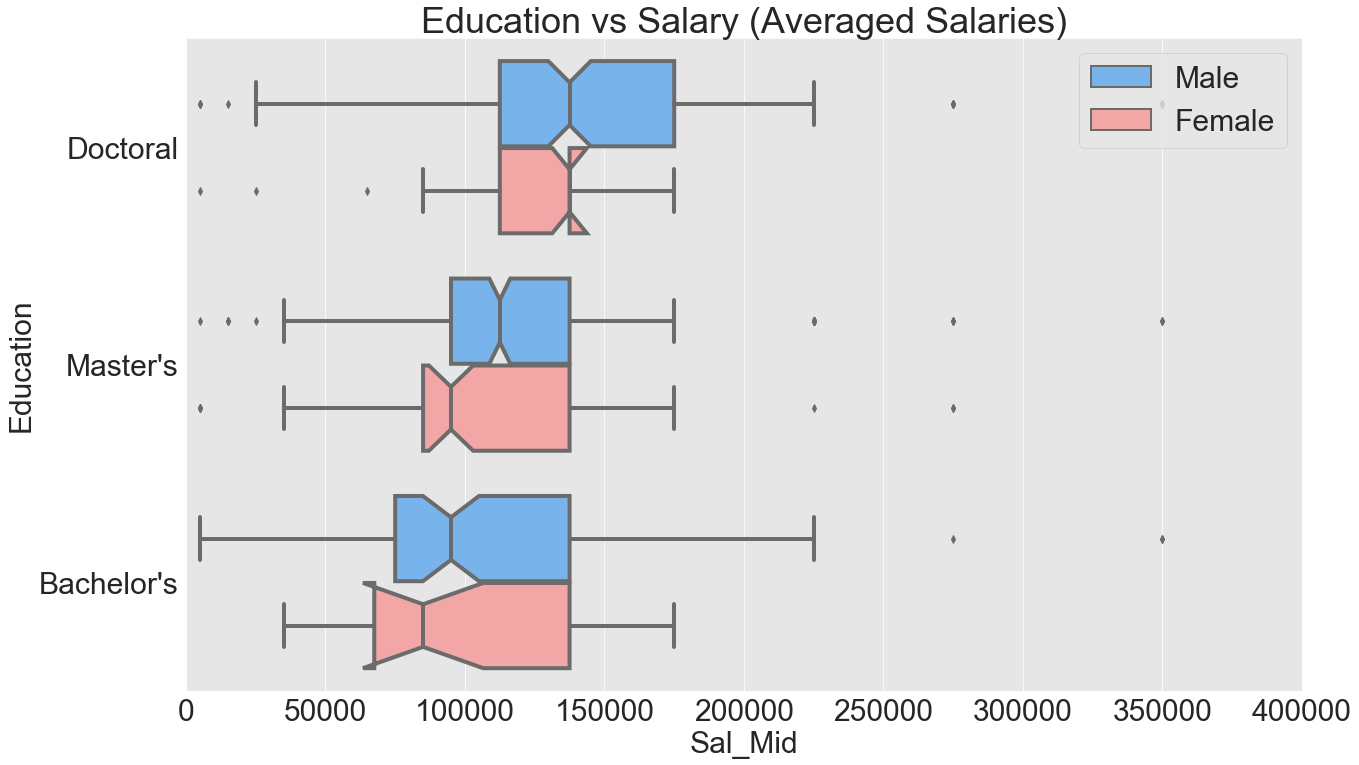

Doctoral's Male vs Female p-value: 0.007
Master's's Male vs Female p-value: 0.000
Bachelor's's Male vs Female p-value: 0.337


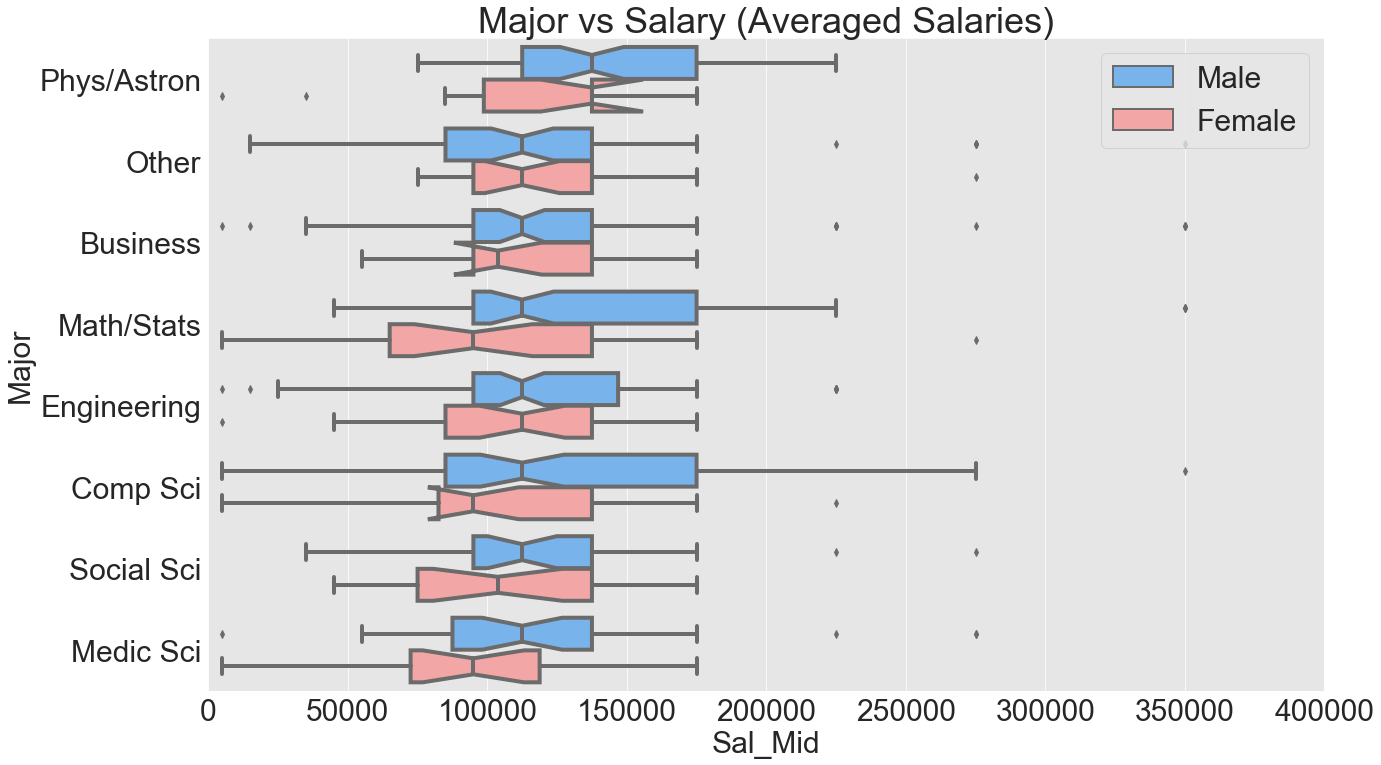

Phys/Astron's Male vs Female p-value: 0.098
Other's Male vs Female p-value: 0.876
Business's Male vs Female p-value: 0.099
Math/Stats's Male vs Female p-value: 0.016
Engineering's Male vs Female p-value: 0.149
Comp Sci's Male vs Female p-value: 0.098
Social Sci's Male vs Female p-value: 0.244
Medic Sci's Male vs Female p-value: 0.067


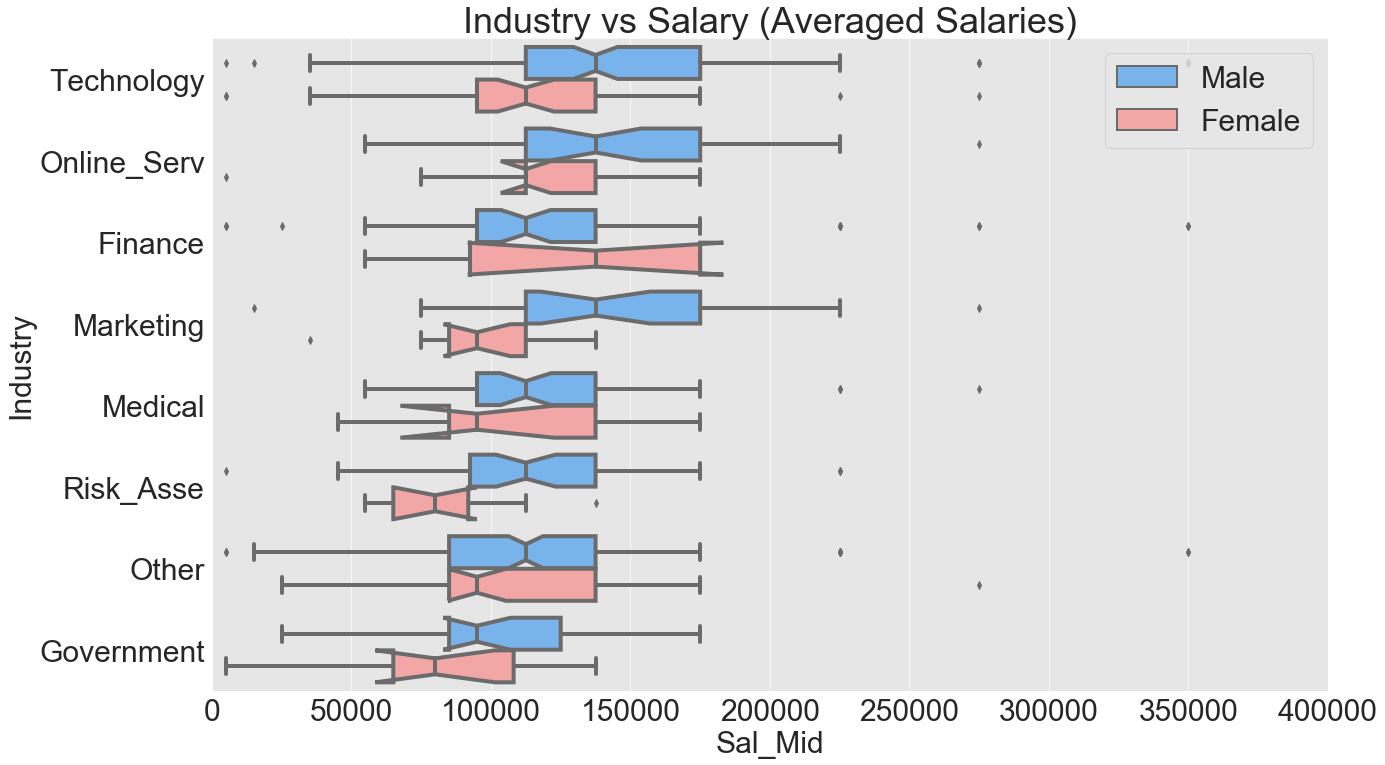

Technology's Male vs Female p-value: 0.006
Online_Serv's Male vs Female p-value: 0.096
Finance's Male vs Female p-value: 0.693
Marketing's Male vs Female p-value: 0.002
Medical's Male vs Female p-value: 0.309
Risk_Asse's Male vs Female p-value: 0.011
Other's Male vs Female p-value: 0.194
Government's Male vs Female p-value: 0.121


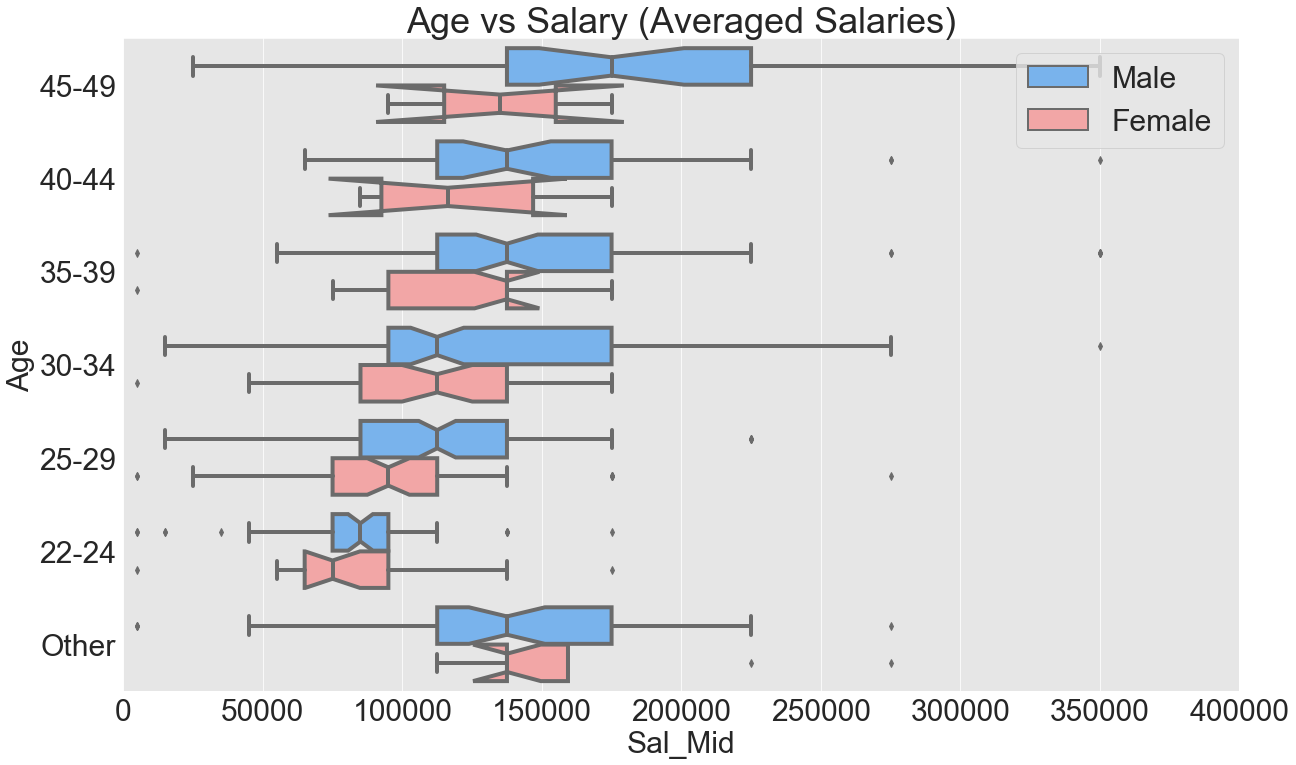

45-49's Male vs Female p-value: 0.436
40-44's Male vs Female p-value: 0.192
35-39's Male vs Female p-value: 0.002
30-34's Male vs Female p-value: 0.016
25-29's Male vs Female p-value: 0.194
22-24's Male vs Female p-value: 0.933
Other's Male vs Female p-value: 0.225


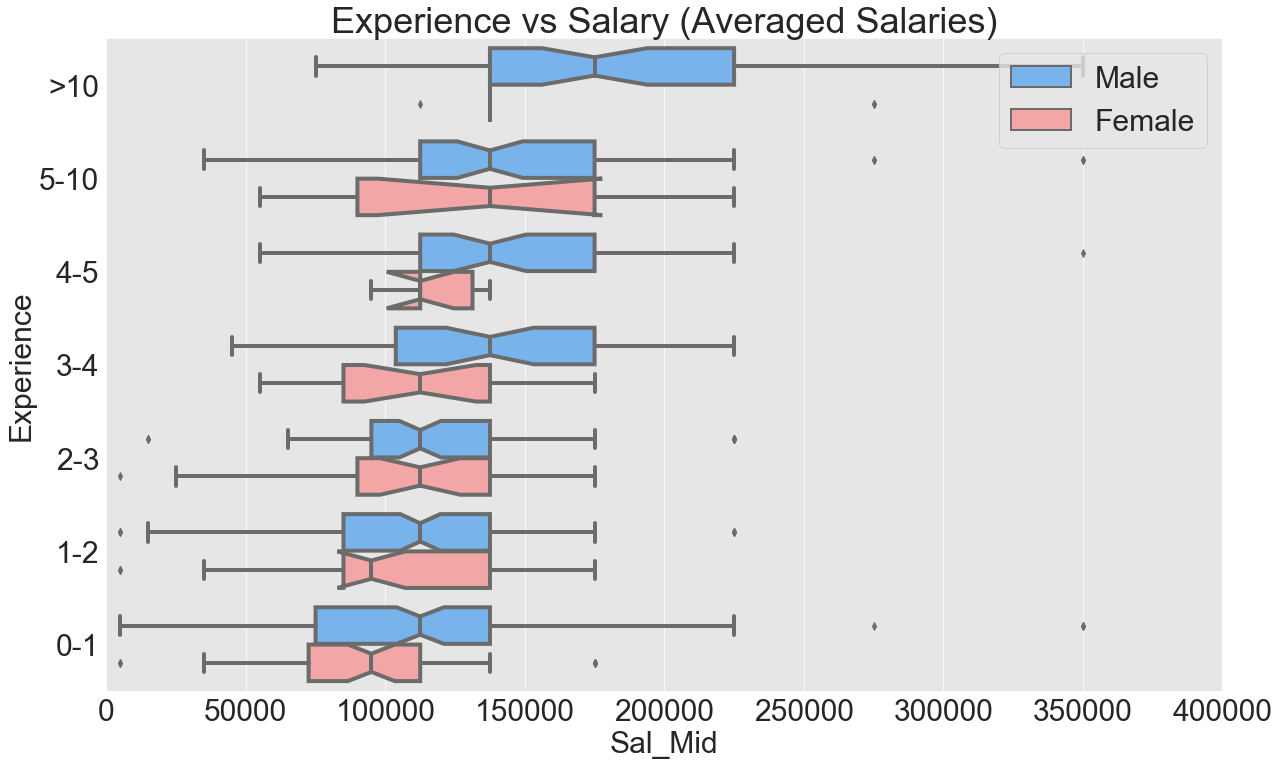

>10's Male vs Female p-value: 0.172
5-10's Male vs Female p-value: 0.266
4-5's Male vs Female p-value: 0.014
3-4's Male vs Female p-value: 0.136
2-3's Male vs Female p-value: 0.099
1-2's Male vs Female p-value: 0.509
0-1's Male vs Female p-value: 0.122


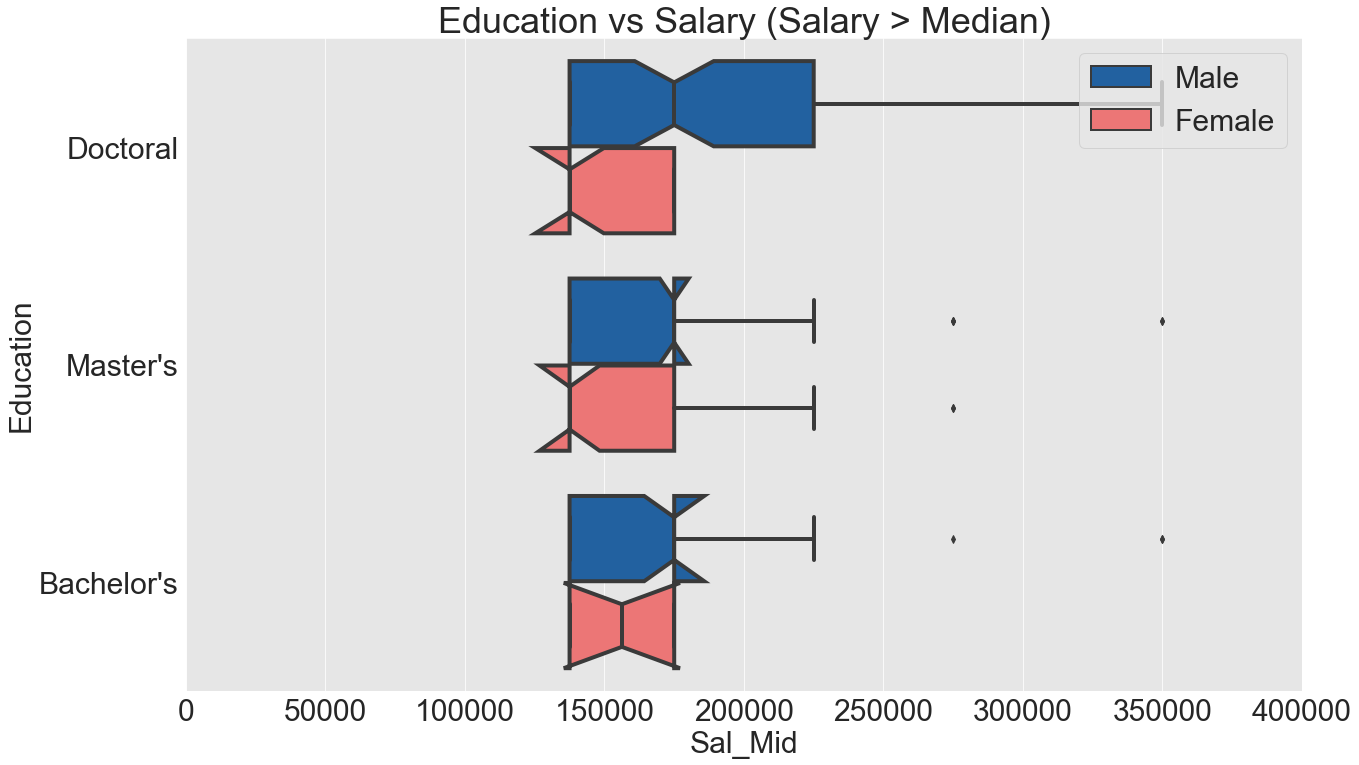

Doctoral's Male vs Female p-value: 0.000
Master's's Male vs Female p-value: 0.084
Bachelor's's Male vs Female p-value: 0.163


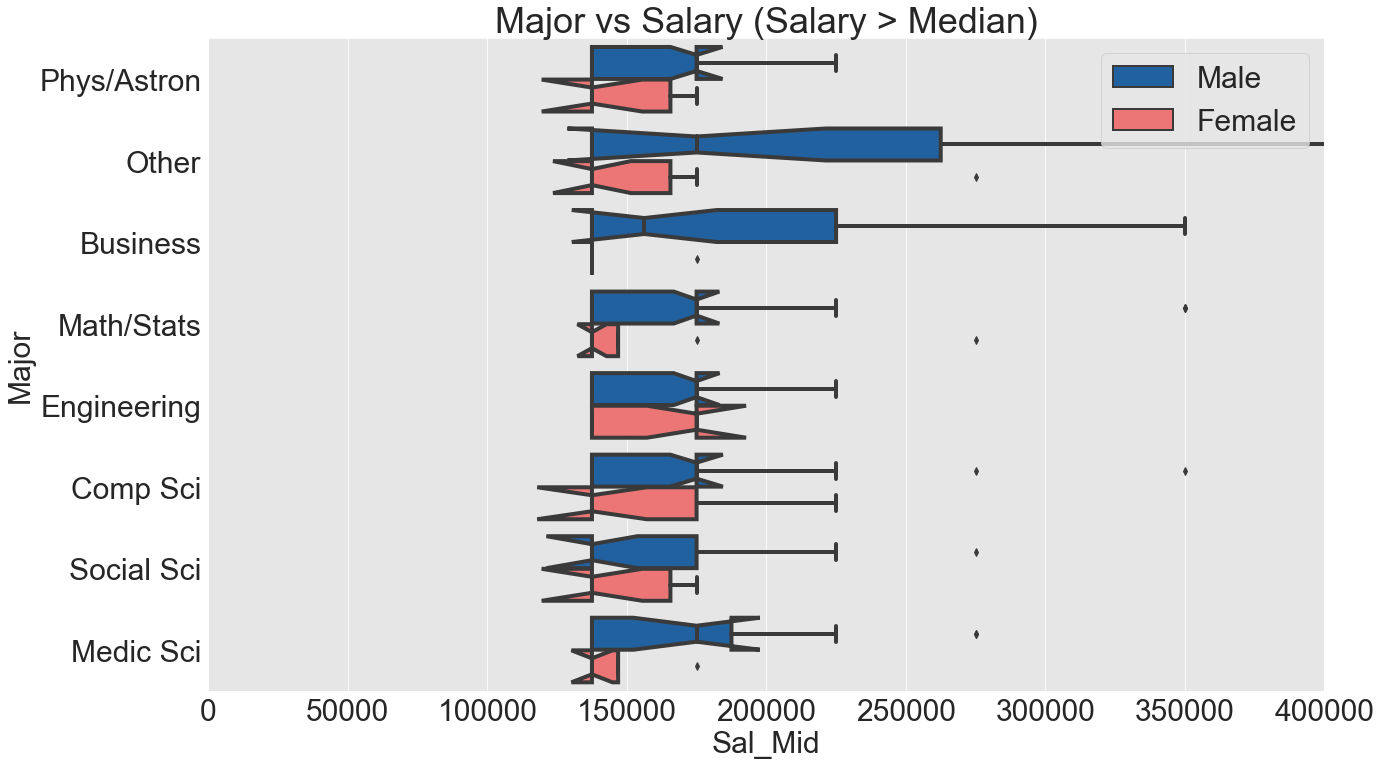

Phys/Astron's Male vs Female p-value: 0.024
Other's Male vs Female p-value: 0.076
Business's Male vs Female p-value: 0.005
Math/Stats's Male vs Female p-value: 0.333
Engineering's Male vs Female p-value: 0.469
Comp Sci's Male vs Female p-value: 0.118
Social Sci's Male vs Female p-value: 0.359
Medic Sci's Male vs Female p-value: 0.079


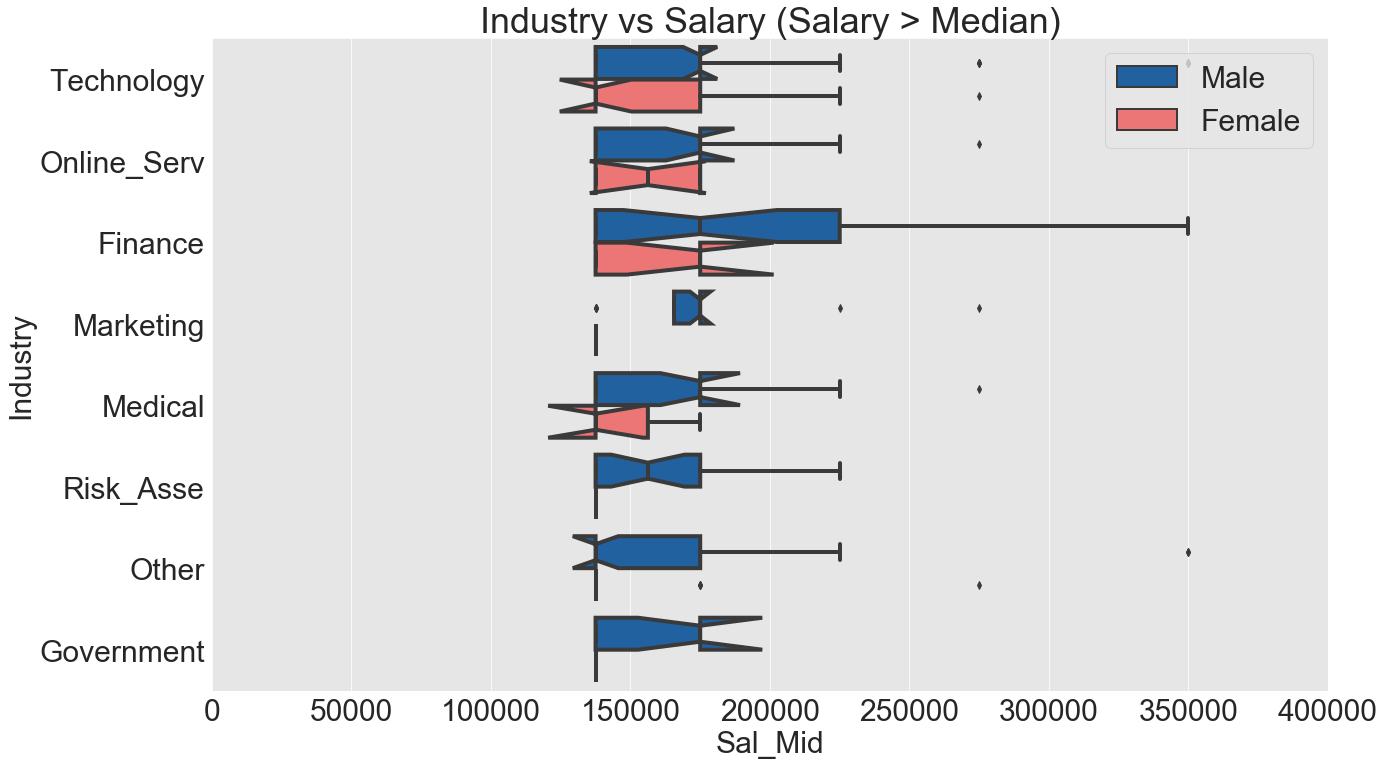

Technology's Male vs Female p-value: 0.025
Online_Serv's Male vs Female p-value: 0.160
Finance's Male vs Female p-value: 0.048
Marketing's Male vs Female p-value: 0.001
Medical's Male vs Female p-value: 0.235
Risk_Asse's Male vs Female p-value: nan
Other's Male vs Female p-value: 0.077
Government's Male vs Female p-value: 0.030


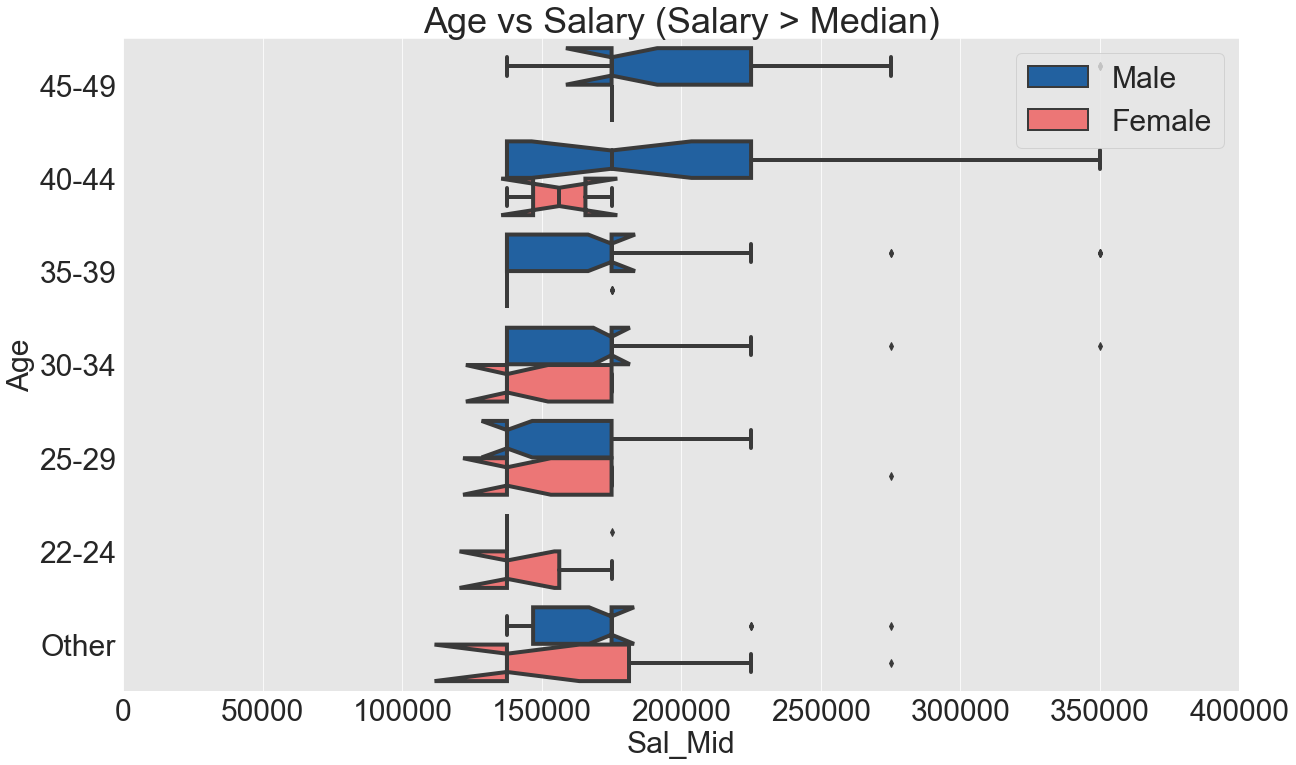

45-49's Male vs Female p-value: nan
40-44's Male vs Female p-value: 0.216
35-39's Male vs Female p-value: 0.000
30-34's Male vs Female p-value: 0.007
25-29's Male vs Female p-value: 0.957
22-24's Male vs Female p-value: 0.751
Other's Male vs Female p-value: 0.873


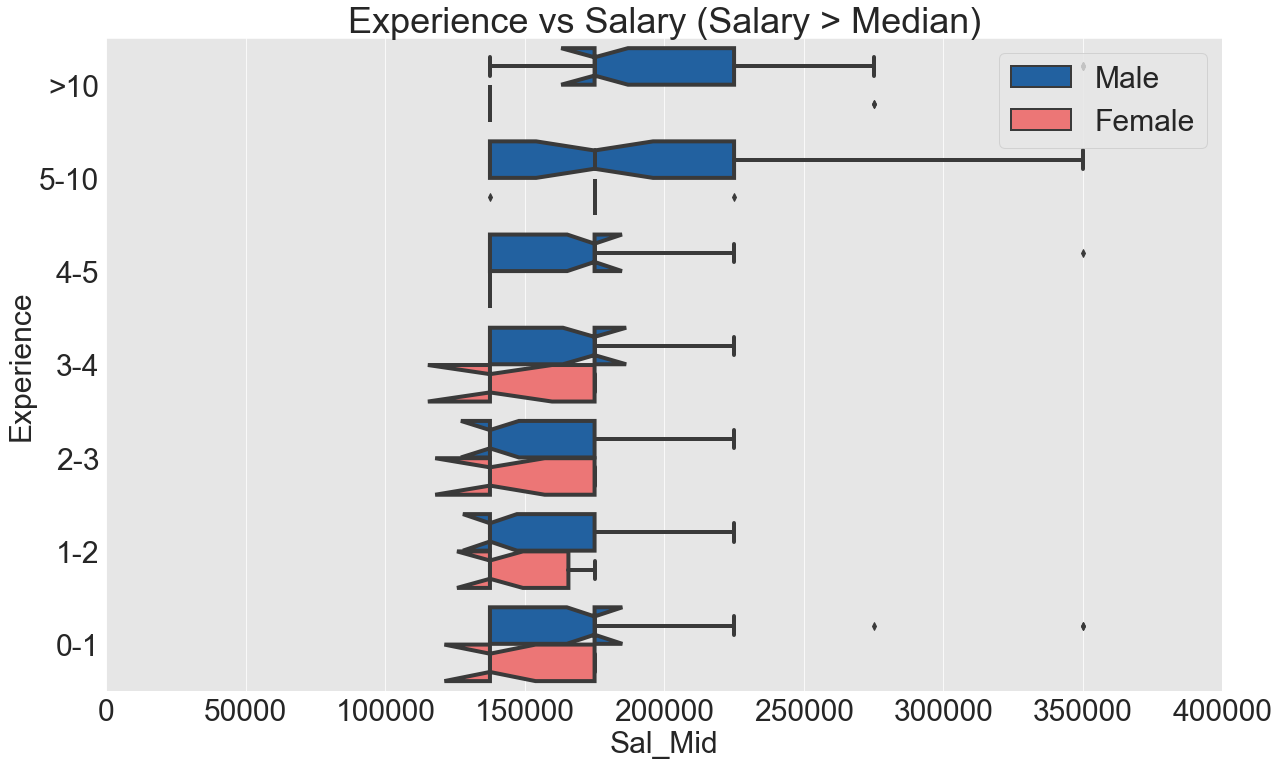

>10's Male vs Female p-value: 0.053
5-10's Male vs Female p-value: 0.366
4-5's Male vs Female p-value: 0.000
3-4's Male vs Female p-value: 0.297
2-3's Male vs Female p-value: 0.071
1-2's Male vs Female p-value: 0.147
0-1's Male vs Female p-value: 0.017


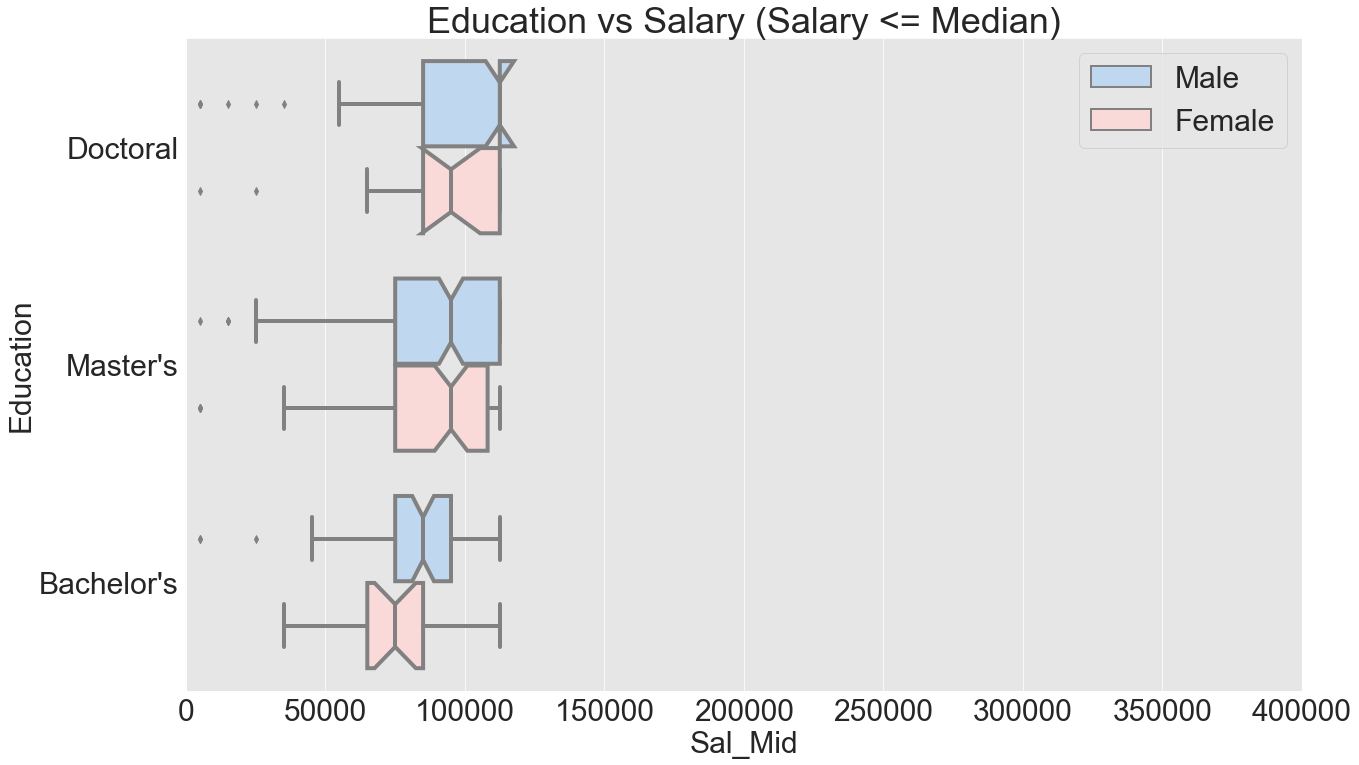

Doctoral's Male vs Female p-value: 0.716
Master's's Male vs Female p-value: 0.059
Bachelor's's Male vs Female p-value: 0.374


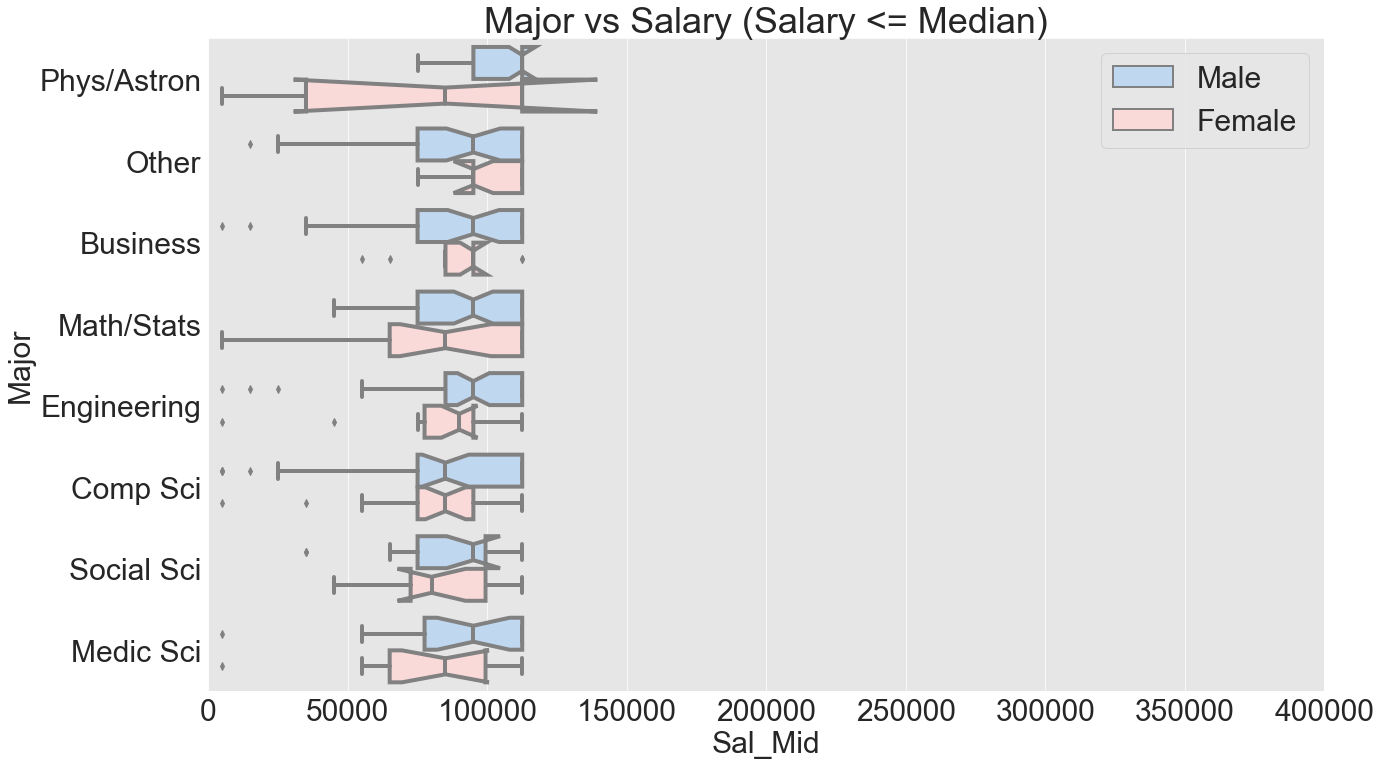

Phys/Astron's Male vs Female p-value: 0.218
Other's Male vs Female p-value: 0.021
Business's Male vs Female p-value: 0.986
Math/Stats's Male vs Female p-value: 0.089
Engineering's Male vs Female p-value: 0.289
Comp Sci's Male vs Female p-value: 0.991
Social Sci's Male vs Female p-value: 0.714
Medic Sci's Male vs Female p-value: 0.482


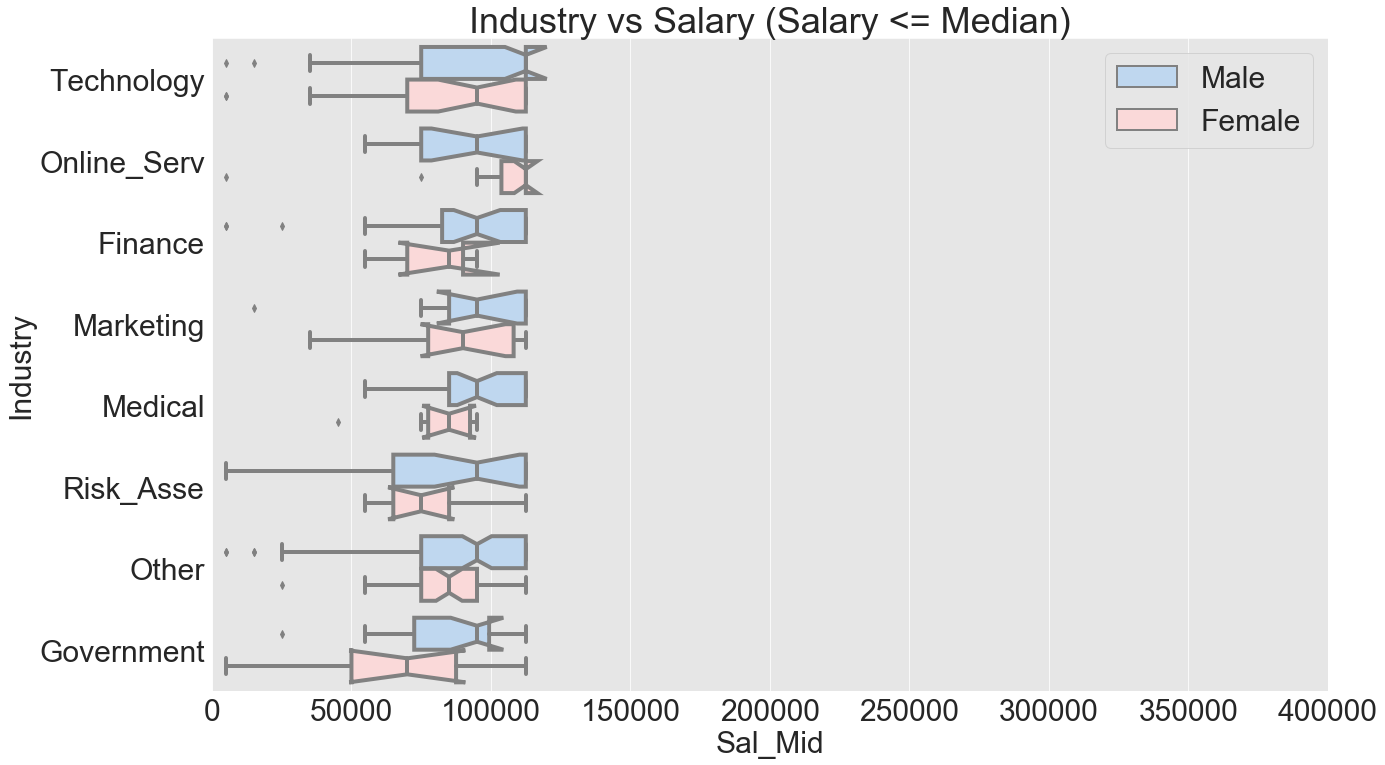

Technology's Male vs Female p-value: 0.266
Online_Serv's Male vs Female p-value: 0.606
Finance's Male vs Female p-value: 0.491
Marketing's Male vs Female p-value: 0.861
Medical's Male vs Female p-value: 0.120
Risk_Asse's Male vs Female p-value: 0.414
Other's Male vs Female p-value: 0.500
Government's Male vs Female p-value: 0.149


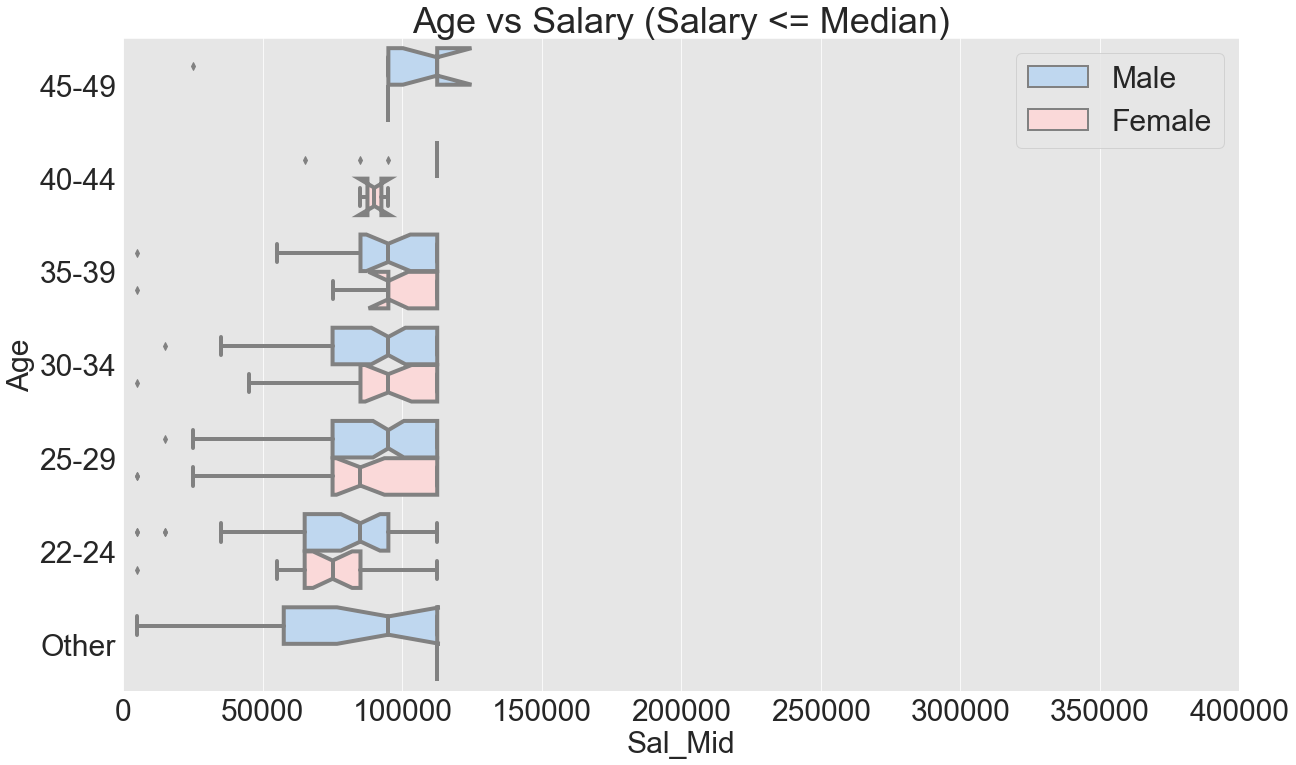

45-49's Male vs Female p-value: nan
40-44's Male vs Female p-value: 0.103
35-39's Male vs Female p-value: 0.895
30-34's Male vs Female p-value: 0.342
25-29's Male vs Female p-value: 0.107
22-24's Male vs Female p-value: 0.715
Other's Male vs Female p-value: nan


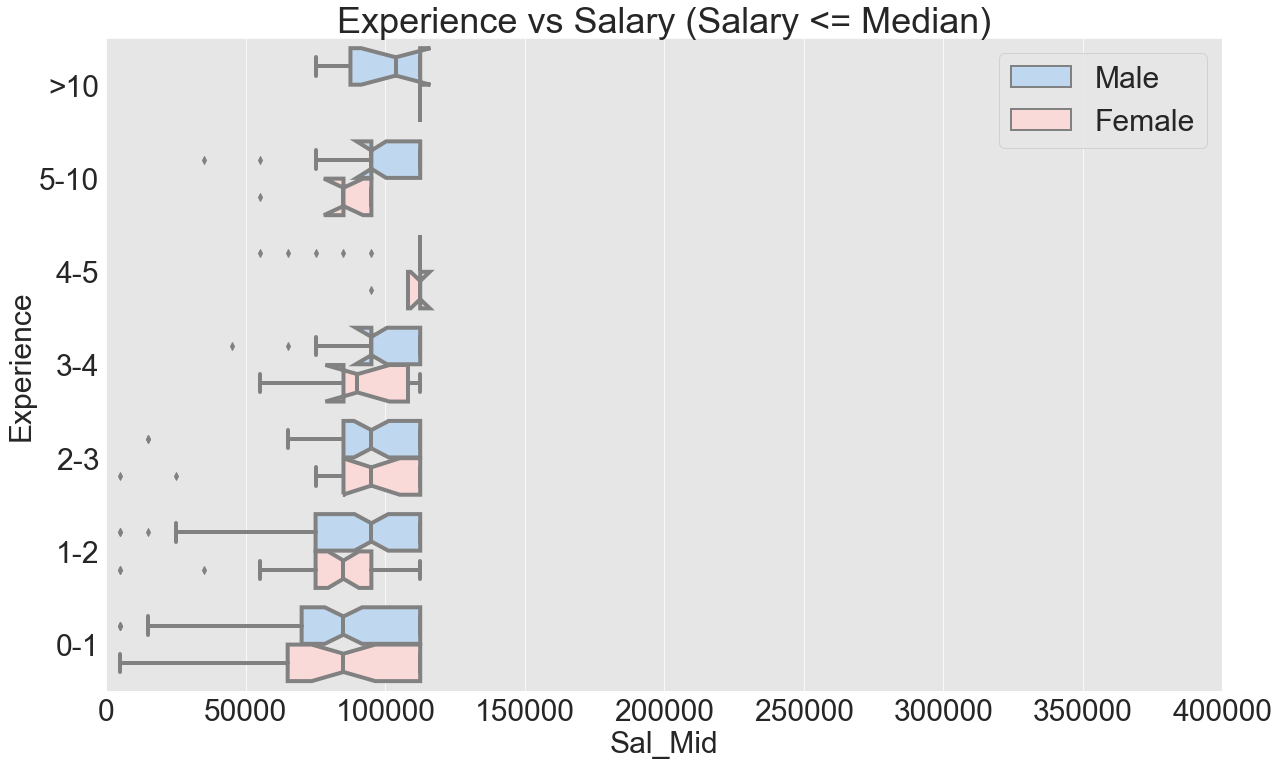

>10's Male vs Female p-value: nan
5-10's Male vs Female p-value: 0.112
4-5's Male vs Female p-value: 0.457
3-4's Male vs Female p-value: 0.297
2-3's Male vs Female p-value: 0.487
1-2's Male vs Female p-value: 0.395
0-1's Male vs Female p-value: 0.583


In [24]:
def gen_t_test(df, feature, subfeature):
    # example: gen_t_test(df,"Education","Bachelor's")
    m_df = df[df["Gender"] == "Male"]
    f_df = df[df["Gender"] == "Female"]
    t,p = stats.ttest_ind(m_df.Sal_Mid[m_df[feature] == subfeature],
                          f_df.Sal_Mid[f_df[feature] == subfeature], equal_var = False)
    print(subfeature + "'s", "Male vs Female p-value:", "{:.3f}".format(p))
    
    #Gen stands for Gender; for exploring if Simpson's Paradox is occurring

def gen_plot(df, column, order, palette):
    if palette == gen:
        title = "(Averaged Salaries)"
        
    if palette == gen_top:
        title = "(Salary > Median)"
        
    if palette == gen_btm:
        title = "(Salary <= Median)"  
        
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.figure(figsize = (20, 12))
    mpl.rcParams['font.size'] = 30

    sns.boxplot(x = df["Sal_Mid"], y = df[column], notch=True,
                hue = df["Gender"], hue_order = ["Male","Female"],
                linewidth = 4, palette = palette, order = order)
    #sns.swarmplot(x = df["Sal_Mid"], y = df[column],
    #              hue = df["Gender"], hue_order = ["Male","Female"],
    #              color = "white",order = order)

    plt.xlim(0,400000)
    plt.title(column + " vs Salary " + title)
    plt.legend(loc="upper right")
    return plt.show()

def gen_plot_t_test(df, feature, subfeatures, palette):
    gen_plot(df, feature, subfeatures, palette)
    for subfeature in subfeatures:
        gen_t_test(df, feature, subfeature)

def gen_check(df, feature, palette):
    if feature == "Experience":
        subfeatures = exp_order
        gen_plot_t_test(df, feature, subfeatures, palette)
       
    if feature == "Major":
        subfeatures = maj_order
        gen_plot_t_test(df, feature, subfeatures, palette)
            
    if feature == "Industry":
        subfeatures = ind_order
        gen_plot_t_test(df, feature, subfeatures, palette)
            
    if feature == "Education":
        subfeatures = edu_order
        gen_plot_t_test(df, feature, subfeatures, palette)
           
    if feature == "Age":
        subfeatures = age_order
        gen_plot_t_test(df, feature, subfeatures, palette)
    
for feature in df.columns:
    gen_check(df, feature, gen)
    
for feature in top_df.columns:
    gen_check(top_df, feature, gen_top)
    
for feature in btm_df.columns:
    gen_check(btm_df, feature, gen_btm)

<div class = "span alert alert-info">
    <h2> Logisitic Regression </h2>
    </div>

In [26]:
df.head()

Gender Education        Major     Industry    Age Experience       Salary  \
11    Male  Master's  Engineering        Other  40-44       5-10  125-150,000   
63    Male  Doctoral   Social Sci      Medical  30-34        3-4  125-150,000   
72  Female  Doctoral   Social Sci        Other  35-39        >10  125-150,000   
91    Male  Master's        Other  Online_Serv  35-39        1-2  125-150,000   
97    Male  Doctoral  Engineering    Risk_Asse  25-29        0-1  125-150,000   

    Age_Mid  Experience_Mid  Sal_Mid  Sal_Lor  
11     42.0             7.5   137500     True  
63     32.0             3.5   137500     True  
72     37.0            12.5   137500     True  
91     37.0             1.5   137500     True  
97     27.0             0.5   137500     True

In [27]:
df.Sal_Lor.value_counts()

False    437
True     314
Name: Sal_Lor, dtype: int64

In [28]:
# ML df using One Hot Encoding
x = pd.get_dummies(df[['Gender', 'Age', 'Education', 'Major', 'Industry', 'Experience']])
y = df[['Sal_Lor']]

In [29]:
def cv_optimize(clf, grid, x_train, y_train, n_folds=5):
    gs = GridSearchCV(clf, param_grid=grid, cv=n_folds)
    gs.fit(x_train, y_train)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

def do_classify(clf, grid, features, target, target1val, standardize=False, train_size=0.8):
    subdf=features
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    x=subdfstd.values
    y=(target.values==target1val)*1
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
    clf = cv_optimize(clf, grid, x_train, y_train)
    clf=clf.fit(x_train, y_train)
    training_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf#, x_train, y_train, x_test, y_test

clf = LogisticRegression()
grid = {"C" : [0.001, 0.1, 1, 10, 100]}

In [30]:
do_classify(clf, grid, x, y, 1)

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.73
Accuracy on test data:     0.66


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
logit_model=sm.Logit(y,x)
print(logit_model.fit().summary2())

Optimization terminated successfully.
         Current function value: 0.535109
         Iterations 6
                                    Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.213     
Dependent Variable:        Sal_Lor                 AIC:                     863.7345  
Date:                      2019-09-06 12:18        BIC:                     1002.3766 
No. Observations:          751                     Log-Likelihood:          -401.87   
Df Model:                  29                      LL-Null:                 -510.44   
Df Residuals:              721                     LLR p-value:             1.0592e-30
Converged:                 1.0000                  Scale:                   1.0000    
No. Iterations:            6.0000                                                     
--------------------------------------------------------------------------------------
                      Coef.     Std.Err.      z    P>|z|      [0